# Advent of code 2019

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2019/advent_of_code_2019.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2019/advent_of_code_2019.ipynb)
by [Hugues Hoppe](http://hhoppe.com/) with Python solutions to the
[2019 Advent of Code puzzles](https://adventofcode.com/2019),
mostly completed in March 2021.

We explore both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 2 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results (obtained by setting `SHOW_BIG_MEDIA = True`):

<p>
<a href="#day10">day10</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day10.gif" width="150">&emsp;
<a href="#day11">day11</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day11a.gif" width="200">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day11b.gif" width="200">
</p>
<p>
<a href="#day13">day13</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day13.gif" width="250">&emsp;
<a href="#day15">day15</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day15a.gif" width="150">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day15b.gif" width="150">
</p>
<p>
<a href="#day17">day17</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day17.png" width="100">
<a href="#day18">day18</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day18a.gif" width="220">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day18b.gif" width="220">&emsp;
<a href="#day19">day19</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day19b.png" width="180">
</p>
<p>
<a href="#day20">day20</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day20a.gif" width="250">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day20b.gif" width="250">&emsp;
<a href="#day24">day24</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2019/results/day24.gif" width="250">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-ocr advent-of-code-hhoppe hhoppe-tools mediapy more-itertools numba

In [3]:
from __future__ import annotations

import abc
import collections
from collections.abc import Iterable, Sequence
import dataclasses
import functools
import heapq
import itertools
import math
import random
import re
import sys
import types
import textwrap
from typing import Any

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import advent_of_code_ocr  # https://github.com/bsoyka/advent-of-code-ocr/blob/main/advent_of_code_ocr/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import mediapy as media
import more_itertools
import numpy as np

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2019
SHOW_BIG_MEDIA = False

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
TAR_URL = f'https://github.com/hhoppe/advent_of_code_{YEAR}/raw/main/data/{PROFILE}.tar.gz'
if 1:
  hh.run(f"if [ ! -d data/{PROFILE} ]; then (mkdir -p data && cd data &&"
         f" wget -q {TAR_URL} && tar xzf {PROFILE}.tar.gz); fi")
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL is not found, we may try adventofcode.com using a session cookie:
if 0:
  # !rm -f ~/.config/aocd/token*; mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token
  # where "53616..." is the session cookie from "adventofcode.com" (valid 1 month).
  hh.run('pip install -q advent-of-code-data')  # https://github.com/wimglenn/advent-of-code-data
  import aocd  # pylint: disable=unused-import # noqa

In [9]:
try:
  import numba
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

In [10]:
advent = advent_of_code_hhoppe.Advent(year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq
_ORIGINAL_GLOBALS = list(globals())

### `Machine` used in several puzzles

In [13]:
# Also called `IntCode` Machine in the puzzles.

class Machine:

  def __init__(self):
    self.mem: Sequence[int] = ()
    self.terminated = False
    self._pc = 0
    self._relative_base = 0

  @abc.abstractmethod
  def run_until_need_input(self, input: list[int]) -> list[int]:
    ...

  @abc.abstractmethod
  def run_fully(self, input: list[int] | None = None) -> list[int]:
    ...

  @staticmethod
  def make(*args, **kwargs):
    if using_numba:
      return NumbaMachine(*args, **kwargs)
    return PyMachine(*args, **kwargs)

In [14]:
class PyMachine(Machine):

  def __init__(self, s, *, mem_extend=0):
    assert not mem_extend
    super().__init__()
    self.mem: list[int] = list(map(int, s.split(',')))
    self._input = []
    self._output = []

  def _execute_one_instruction(self):
    assert not self.terminated
    code = self.mem[self._pc]
    opcode = code % 100

    def possibly_grow_memory_to_access(i):
      assert 0 <= i < 1_000_000, i
      if i >= len(self.mem):
        self.mem += [0] * i  # grow quickly

    def read(i):
      possibly_grow_memory_to_access(i)
      return self.mem[i]

    def write(i, value):
      possibly_grow_memory_to_access(i)
      self.mem[i] = value

    def address(i):
      mode = (code // (10**(i + 1))) % 10
      if mode == 0:  # position mode
        return self.mem[self._pc + i]
      if mode == 2:  # relative mode
        return self._relative_base + self.mem[self._pc + i]
      raise RuntimeError(f'Unrecognized lhs mode {mode})')

    def operand(i):
      mode = (code // (10**(i + 1))) % 10
      if mode in (0, 2):
        return read(address(i))
      if mode == 1:  # immediate mode
        return self.mem[self._pc + i]
      raise RuntimeError(f'Unrecognized rhs mode {mode})')

    if opcode == 99:  # End
      assert not self._input
      self.terminated = True
    elif opcode == 1:  # Add
      write(address(3), operand(1) + operand(2))
      self._pc += 4
    elif opcode == 2:  # Multiply
      write(address(3), operand(1) * operand(2))
      self._pc += 4
    elif opcode == 3:  # Input
      write(address(1), self._input.pop(0))
      self._pc += 2
    elif opcode == 4:  # Output
      self._output.append(operand(1))
      self._pc += 2
    elif opcode == 5:  # Jump if true
      self._pc = operand(2) if operand(1) != 0 else self._pc + 3
    elif opcode == 6:  # Jump if false
      self._pc = operand(2) if operand(1) == 0 else self._pc + 3
    elif opcode == 7:  # Less
      write(address(3), int(operand(1) < operand(2)))
      self._pc += 4
    elif opcode == 8:  # Equal
      write(address(3), int(operand(1) == operand(2)))
      self._pc += 4
    elif opcode == 9:  # Adjust relative base
      self._relative_base += operand(1)
      self._pc += 2
    else:
      raise RuntimeError(f'Unrecognized opcode {opcode} (pc={self._pc})')

  def run_until_need_input(self, input: list[int]) -> list[int]:

    def next_opcode_is_input():
      return self.mem[self._pc] == 3

    assert not self.terminated
    assert not self._output
    self._input = input if input is not None else []
    while not self.terminated:
      if next_opcode_is_input() and not self._input:
        break
      self._execute_one_instruction()
    assert not self._input
    output = self._output
    self._output = []
    return output

  def run_fully(self, input: list[int] | None = None) -> list[int]:
    output = self.run_until_need_input(input if input is not None else [])
    assert self.terminated
    return output


def test_machine_py():
  def mem_after_machine_run(s):
    machine = PyMachine(s)
    machine.run_fully()
    return ','.join(map(str, machine.mem))

  s1 = '1,9,10,3,2,3,11,0,99,30,40,50'
  check_eq(mem_after_machine_run(s1), '3500,9,10,70,2,3,11,0,99,30,40,50')

  check_eq(mem_after_machine_run('1,0,0,0,99'), '2,0,0,0,99')  # 1 + 1 = 2
  check_eq(mem_after_machine_run('2,3,0,3,99'), '2,3,0,6,99')  # 3 * 2 = 6
  check_eq(mem_after_machine_run('2,4,4,5,99,0'), '2,4,4,5,99,9801')  # 99 * 99
  check_eq(mem_after_machine_run('1,1,1,4,99,5,6,0,99'), '30,1,1,4,2,5,6,0,99')

test_machine_py()

In [15]:
class NumbaMachine(Machine):

  def __init__(self, s, *, mem_extend=10_000):
    super().__init__()
    # Preallocate extra memory because we do not grow it as in PyMachine.
    self.mem = np.concatenate((np.array(list(map(int, s.split(',')))),
                               np.zeros(mem_extend, np.int64)))

  @staticmethod
  @numba.njit
  def _run(mem, pc, relative_base, input):
    input_index = 0
    output = []
    terminated = False

    while not terminated:
      code = mem[pc]
      opcode = code % 100
      if opcode == 3 and input_index == input.size:  # must wait for input
        break

      def read(i):
        return mem[i]

      def write(i, value):
        mem[i] = value

      def address(i):
        mode = (code // (10**(i + 1))) % 10
        if mode == 0:  # position mode
          return mem[pc + i]
        assert mode == 2  # relative mode
        return relative_base + mem[pc + i]

      def operand(i):
        mode = (code // (10**(i + 1))) % 10
        if mode in (0, 2):
          return read(address(i))
        assert mode == 1  # immediate mode
        return mem[pc + i]

      if opcode == 99:  # End
        assert input_index == input.size
        terminated = True
      elif opcode == 1:  # Add
        write(address(3), operand(1) + operand(2))
        pc += 4
      elif opcode == 2:  # Multiply
        write(address(3), operand(1) * operand(2))
        pc += 4
      elif opcode == 3:  # Input
        write(address(1), input[input_index])
        input_index += 1
        pc += 2
      elif opcode == 4:  # Output
        output.append(operand(1))
        pc += 2
      elif opcode == 5:  # Jump if true
        pc = operand(2) if operand(1) != 0 else pc + 3
      elif opcode == 6:  # Jump if false
        pc = operand(2) if operand(1) == 0 else pc + 3
      elif opcode == 7:  # Less
        write(address(3), int(operand(1) < operand(2)))
        pc += 4
      elif opcode == 8:  # Equal
        write(address(3), int(operand(1) == operand(2)))
        pc += 4
      elif opcode == 9:  # Adjust relative base
        relative_base += operand(1)
        pc += 2
      else:
        assert False

    return pc, relative_base, terminated, output

  def run_until_need_input(self, input: list[int]) -> list[int]:
    assert not self.terminated
    self._pc, self._relative_base, self.terminated, output = self._run(
        self.mem, self._pc, self._relative_base, np.array(input, np.int64))
    return output

  def run_fully(self, input: list[int] | None = None) -> list[int]:
    output = self.run_until_need_input(input if input is not None else [])
    assert self.terminated
    return output

In [16]:
def test_machine(machine_type):
  def mem_after_machine_run(s):
    machine = machine_type(s, mem_extend=0)
    machine.run_fully()
    return ','.join(map(str, machine.mem))

  s1 = '1,9,10,3,2,3,11,0,99,30,40,50'
  check_eq(mem_after_machine_run(s1), '3500,9,10,70,2,3,11,0,99,30,40,50')

  check_eq(mem_after_machine_run('1,0,0,0,99'), '2,0,0,0,99')  # 1 + 1 = 2
  check_eq(mem_after_machine_run('2,3,0,3,99'), '2,3,0,6,99')  # 3 * 2 = 6
  check_eq(mem_after_machine_run('2,4,4,5,99,0'), '2,4,4,5,99,9801')  # 99 * 99
  check_eq(mem_after_machine_run('1,1,1,4,99,5,6,0,99'), '30,1,1,4,2,5,6,0,99')


for _machine_type in (PyMachine, NumbaMachine):
  test_machine(_machine_type)  # ~4 s for numba compilation.

In [17]:
if 0:  # For quick timing test while developing.
  puzzle = advent.puzzle(day=13, silent=True)

  def run_game(s):
    machine = Machine.make(s)
    machine.mem[0] = 2  # set free play
    score = None
    last_yx = {}
    input = []

    while not machine.terminated:
      output = machine.run_until_need_input(input)
      for x, y, tile_id in more_itertools.chunked(output, 3):
        if (x, y) == (-1, 0):
          score = tile_id
        elif tile_id in (4, 3):  # ball or paddle
          last_yx[tile_id] = y, x
      joystick = np.sign(last_yx[4][1] - last_yx[3][1])  # ball.x - paddle.x
      input = [joystick]
    return score

  puzzle.verify(2, run_game)  # ~60 ms with NumbaMachine; ~3 s without.

<a name="day1"></a>
## Day 1: Fuel mass

Given space modules with mass, report sum of fuel requirements.

- Part 1: To find the fuel required for a module, take its mass, divide by three, round down, and subtract 2.

- Part 2: The fuel itself has mass and requires additional fuel, recursively.

In [18]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2019/day/1), `puzzle.input` has 100 lines:

115810
58892
76569
87782
103850
103320
62798
98400
 ...
138309
107308
146818
63364


The stored answers are: `{1: '3235550', 2: '4850462'}`

In [19]:
def day1(s, *, part2=False):

  def get_fuel(mass):
    return max(mass // 3 - 2, 0)

  check_eq(get_fuel(0), 0)
  check_eq(get_fuel(12), 2)
  check_eq(get_fuel(14), 2)
  check_eq(get_fuel(1969), 654)
  check_eq(get_fuel(100756), 33583)

  def get_adjusted_fuel(mass):
    if fuel := get_fuel(mass):
      fuel += get_adjusted_fuel(fuel)
    return fuel

  check_eq(get_adjusted_fuel(14), 2)
  check_eq(get_adjusted_fuel(1969), 966)
  check_eq(get_adjusted_fuel(100756), 50346)

  func = get_adjusted_fuel if part2 else get_fuel
  return sum(func(int(mass)) for mass in s.split())


puzzle.verify(1, day1)  # ~1 ms.
day1_part2 = functools.partial(day1, part2=True)
puzzle.verify(2, day1_part2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Machine with add/subtract

Create Intcode computer with opcodes for addition, subtraction, and termination.

- Part 1: Before running the program, replace position 1 with the value 12 and replace position 2 with the value 2.  Report value is at position 0 after the program halts.

- Part 2: Determine what pair of inputs (at addresses 1 and 2) produces the output 19690720 (at address 0).

In [20]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2019/day/2), `puzzle.input` has a single line of 420 characters:

1,0,0,3,1,1,2,3,1,3,4,3,1,5,0,3,2,13,1,19,1,10,19,23,1,23,9,27,1,5,27,31,2,31,13 ... ,1,2,143,147,1,147,10,0,99,2,0,14,0


The stored answers are: `{1: '4930687', 2: '5335'}`

In [21]:
def day2a(s, *, part2=False):  # Original implementation before Machine.

  def day2_machine_op(s, a=12, b=2):
    l = list(map(int, s.split(',')))
    l[1] = a
    l[2] = b
    i = 0
    while l[i] != 99:
      if l[i] == 1:
        l[l[i + 3]] = l[l[i + 1]] + l[l[i + 2]]
        i += 4
      elif l[i] == 2:
        l[l[i + 3]] = l[l[i + 1]] * l[l[i + 2]]
        i += 4
      else:
        raise RuntimeError(f'? {l}')
    return l[0]

  if not part2:
    return day2_machine_op(s)

  for a_plus_b in range(200):
    for a in range(min(a_plus_b, 100)):
      b = a_plus_b - a
      if day2_machine_op(s, a, b) == 19690720:
        # hh.show(a, b)
        return a * 100 + b


puzzle.verify(1, day2a)  # ~0 ms.
day2a_part2 = functools.partial(day2a, part2=True)
puzzle.verify(2, day2a_part2)  # ~175 ms.

(Part 1: 0.000 s)
(Part 2: 0.051 s)


In [22]:
def day2(s, *, part2=False):  # Now using Machine class.

  def day2_machine_op(s, a=12, b=2):
    machine = Machine.make(s)
    machine.mem[1:3] = a, b
    machine.run_fully()
    return machine.mem[0]

  if not part2:
    return day2_machine_op(s)

  for a_plus_b in range(200):
    for a in range(min(a_plus_b, 100)):
      b = a_plus_b - a
      if day2_machine_op(s, a, b) == 19690720:
        # hh.show(a, b)
        return a * 100 + b


puzzle.verify(1, day2)  # ~0 ms.
day2_part2 = functools.partial(day2, part2=True)
puzzle.verify(2, day2_part2)  # ~220 ms with NumbaMachine; ~900 ms without.

(Part 1: 0.001 s)
(Part 2: 0.088 s)


<a name="day3"></a>
## Day 3: Intersections of two paths

Given two paths, each described as a sequence of comma-separated axis-movements `[UDLR]value`:

- Part 1: Find the Manhattan distance from the origin to the closest intersection of the two paths.

- Part 2: Compute the number of steps along the path to each intersection.  Report the fewest combined steps the two paths must take to reach an intersection.

In [23]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2019/day/3), `puzzle.input` has 2 lines:

R1003,D138,L341,U798,L922,U153,R721,D177,L297,D559,L414,U470,L589,D179,L267,D954 ... 9,L641,U73,L294,D247,R944,U512,L396
L1004,D252,L909,D935,R918,D981,L251,U486,R266,U613,L546,D815,L789,D692,L550,U633 ... U447,R966,U346,L636,D9,L480,D35,R96


The stored answers are: `{1: '446', 2: '9006'}`

In [24]:
s1 = """\
R8,U5,L5,D3
U7,R6,D4,L4
"""

s2 = """\
R75,D30,R83,U83,L12,D49,R71,U7,L72
U62,R66,U55,R34,D71,R55,D58,R83
"""

s3 = """\
R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51
U98,R91,D20,R16,D67,R40,U7,R15,U6,R7
"""

In [25]:
def day3a_part1(s):  # Abandonned slow version, using large 2D images.
  shape = 20, 20  # Y, X
  origin = np.array(shape) // 2

  def vec_from_move(move: str) -> np.ndarray:
    dir, mag = move[:1], int(move[1:])
    if dir == 'L':
      return np.array((0, -mag))
    if dir == 'R':
      return np.array((0, +mag))
    if dir == 'U':
      return np.array((-mag, 0))
    if dir == 'D':
      return np.array((+mag, 0))
    raise RuntimeError(f'Unrecognized move {move}')

  def rasterize(path: str):
    moves = path.split(',')
    position = origin.copy()
    grid = np.full(shape, 0, np.uint8)
    count = 0
    for move in moves:
      vec = vec_from_move(move)
      # print(f'{position=} {vec=}')
      while vec.any():
        step = np.sign(vec)
        vec -= step
        position = position + step
        count += 1
        if not grid[tuple(position)]:
          grid[tuple(position)] = count
    return grid

  path1, path2 = s.splitlines()
  grid1 = rasterize(path1)
  grid2 = rasterize(path2)
  intersect = (grid1 > 0) & (grid2 > 0)
  media.show_images([grid1, grid2, intersect], height=shape[0] * 4)
  intersections = (np.moveaxis(np.indices(shape), 0, -1) - origin)[intersect > 0]
  # print(intersections)
  return abs(intersections).sum(axis=-1).min()


check_eq(day3a_part1(s1), 6)  # [[-5  6] [-3  3]]

,,


In [26]:
def day3b(s, *, part2=False):  # Using a sparse map on 2D positions.

  def rasterize(path: str):
    dyx_from_move = dict(L=(0, -1), R=(0, +1), U=(-1, 0), D=(+1, 0))
    yx = 0, 0
    counts = {}
    count = 0
    for move in path.split(','):
      dyx, magnitude = dyx_from_move[move[:1]], int(move[1:])
      for _ in range(magnitude):
        count += 1
        yx = yx[0] + dyx[0], yx[1] + dyx[1]
        if yx not in counts:
          counts[yx] = count
    if 0:
      print(f'y:{hh.Stats(yx[0] for yx in counts)}')
      print(f'x:{hh.Stats(yx[1] for yx in counts)}')
      # y:(   148791)        -7052 : 1558         av=-1919.52     sd=2129.35
      # x:(   148791)        -5635 : 1003         av=-2209.31     sd=1405.76
      # y:(   157561)       -17468 : 2576         av=-6868.07     sd=6164.86
      # x:(   157561)        -2865 : 9691         av=5058.61      sd=3179.34
      # The paths are a bit too large to store in a grid or visualize.
    return counts

  path1, path2 = s.splitlines()
  counts1 = rasterize(path1)
  counts2 = rasterize(path2)

  if not part2:
    return min(abs(y) + abs(x) for y, x in counts1 if (y, x) in counts2)
  return min((c1 + counts2[pos]) for pos, c1 in counts1.items() if pos in counts2)


check_eq(day3b(s1), 6)  # [(-5, 6), (-3, 3)]
check_eq(day3b(s2), 159)
check_eq(day3b(s3), 135)
puzzle.verify(1, day3b)  # ~230 ms.

day3b_part2 = functools.partial(day3b, part2=True)
check_eq(day3b_part2(s1), 30)
check_eq(day3b_part2(s2), 610)
check_eq(day3b_part2(s3), 410)
puzzle.verify(2, day3b_part2)  # ~230 ms.

(Part 1: 0.096 s)
(Part 2: 0.087 s)


In [27]:
# Using numba to operate on dict is slow.

@numba.njit
def day3_rasterize(path):
  y, x = 0, 0
  counts = {}
  count = 0
  for dy, dx, magnitude in path:
    for _ in range(magnitude):
      count += 1
      y, x = y + dy, x + dx
      if (y, x) not in counts:
        counts[y, x] = count
  return counts


def day3(s, *, part2=False):
  path1, path2 = s.splitlines()
  dyx_from_move = dict(L=(0, -1), R=(0, +1), U=(-1, 0), D=(+1, 0))
  counts1, counts2 = [
      day3_rasterize(np.array([[*dyx_from_move[move[:1]], int(move[1:])]
                               for move in path.split(',')]))
      for path in [path1, path2]
  ]

  if not part2:
    return min(abs(y) + abs(x) for y, x in counts1 if (y, x) in counts2)
  return min((counts1[pos] + counts2[pos]) for pos in counts1 if pos in counts2)


check_eq(day3(s1), 6)  # [(-5, 6), (-3, 3)]
check_eq(day3(s2), 159)
check_eq(day3(s3), 135)
# puzzle.verify(1, day3)  # ~730 ms.

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2(s1), 30)
check_eq(day3_part2(s2), 610)
check_eq(day3_part2(s3), 410)
# puzzle.verify(2, day3_part2)  # ~730 ms.

<a name="day4"></a>
## Day 4: Valid 6-digit passwords

Count the number of 6-digit passwords within the range specified in the input that satisfy:

- Part 1: (a) Two adjacent digits are the same, and (b) the digits never decrease.

- Part 2: and (c) the two adjacent matching digits are not part of a larger group of matching digits.

In [28]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2019/day/4), `puzzle.input` has a single line of 13 characters:

152085-670283


The stored answers are: `{1: '1764', 2: '1196'}`

In [29]:
def day4a(s):  # Slow brute-force.
  lb, ub = map(int, s.split('-'))

  def two_adjacent_are_same(s):
    return any(a == b for a, b in zip(s, s[1:]))

  def digits_never_decrease(s):
    return all(a <= b for a, b in zip(s, s[1:]))

  count = 0
  for i in range(lb, ub + 1):
    s = str(i)
    count += two_adjacent_are_same(s) and digits_never_decrease(s)
  return count


puzzle.verify(1, day4a)  # ~1000 ms.

(Part 1: 0.389 s)


In [30]:
def day4(s, *, part2=False):  # Recursive search with pruning.
  lower, upper = (tuple(map(int, list(b))) for b in s.strip().split('-'))

  def two_adjacent_are_same(t):
    return any(a == b for a, b in zip(t, t[1:]))

  def have_exactly_two_adjacent(t):
    e = (-1, *t, -1)
    return any(a != b and b == c and c != d
               for a, b, c, d in zip(e, e[1:], e[2:], e[3:]))

  def recurse(base):
    count = 0
    for digit in range((base[-1] if base else 0), 10):
      t = base + (digit,)
      if (*t, 10) < lower or t > upper:
        continue
      if len(t) == 6:
        count += (have_exactly_two_adjacent(t) if part2
                  else two_adjacent_are_same(t))
      else:
        count += recurse(t)
    return count

  return recurse(())


puzzle.verify(1, day4)  # ~4 ms.
day4_part2 = functools.partial(day4, part2=True)
puzzle.verify(2, day4_part2)  # ~5 ms.

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day5"></a>
## Day 5: Machine with branching

Extend the Intcode machine to support (1) input/output opcodes and both position and immediate operand modes, then (2) branch and comparison opcodes.

- Part 1: After providing input [1], report the output diagnostic code which comes after a sequence of zeros.

- Part 2: After providing input [5], report the output diagnostic code.

In [31]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2019/day/5), `puzzle.input` has a single line of 2_558 characters:

3,225,1,225,6,6,1100,1,238,225,104,0,1102,91,92,225,1102,85,13,225,1,47,17,224,1 ... ,224,674,101,1,223,223,4,223,99,226


The stored answers are: `{1: '16489636', 2: '9386583'}`

In [32]:
def day5_test():
  for input in (7, 8, 9):
    check_eq(Machine.make('3,9,8,9,10,9,4,9,99,-1,8').run_fully([input]), [input == 8])
  for input in (7, 8, 9):
    check_eq(Machine.make('3,9,7,9,10,9,4,9,99,-1,8').run_fully([input]), [input < 8])
  for input in (7, 8, 9):
    check_eq(Machine.make('3,3,1108,-1,8,3,4,3,99').run_fully([input]), [input == 8])
  for input in (7, 8, 9):
    check_eq(Machine.make('3,3,1107,-1,8,3,4,3,99').run_fully([input]), [input < 8])

  for input in (-1, 0, 1):
    s = '3,12,6,12,15,1,13,14,13,4,13,99,-1,0,1,9'
    check_eq(Machine.make(s).run_fully([input]), [int(input != 0)])
  for input in (-1, 0, 1):
    s = '3,3,1105,-1,9,1101,0,0,12,4,12,99,1'
    check_eq(Machine.make(s).run_fully([input]), [int(input != 0)])

  s = '3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99'
  for input in (7, 8, 9):
    expected = 999 if input < 8 else 1000 if input == 8 else 1001
    check_eq(Machine.make(s).run_fully([input]), [expected])

day5_test()

In [33]:
def day5(s, *, part2=False):
  output = Machine.make(s).run_fully([5 if part2 else 1])
  if part2:
    assert len(output) == 1
    return output[0]
  assert len(output) > 1 and not any(output[:-1])
  return output[-1]


puzzle.verify(1, day5)  # ~0 ms.
day5_part2 = functools.partial(day5, part2=True)
puzzle.verify(2, day5_part2)  # ~0 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day6"></a>
## Day 6: Count orbit transfers

Given a sequence of orbit relationships, where`'A)B'` indicates `B` orbits `A`:

- Part 1: Report the total number of direct and indirect orbits.

- Part 2: Report the number of orbital transfers you (`YOU`) need to take to get to Santa (`SAN`).

In [34]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2019/day/6), `puzzle.input` has 1_069 lines:

FGY)61Z
2BN)LM7
QXY)TVB
5M5)Y6C
2L2)64M
6TT)183
H6P)6TT
LPL)WP5
 ...
SKV)YWS
72M)F1F
3ZK)RSW
1LV)GFH


The stored answers are: `{1: '162816', 2: '304'}`

In [35]:
def day6(s, *, part2=False, source='YOU', destination='SAN'):

  def get_orbit_parents(s):
    parents = {}
    for entry in s.split():
      parent, child = entry.split(')')
      parents[child] = parent
    return parents

  def all_orbits(node):
    return 1 + all_orbits(parents[node]) if node in parents else 0

  parents = get_orbit_parents(s)

  if not part2:
    return sum(all_orbits(node) for node in parents)

  distances = {}
  node = source
  distance = -1
  while node in parents:
    node = parents[node]
    distance += 1
    distances[node] = distance

  node = destination
  distance = -1
  while node not in distances:
    node = parents[node]
    distance += 1

  return distances[node] + distance


s1 = 'COM)B B)C C)D D)E E)F B)G G)H D)I E)J J)K K)L'
check_eq(day6(s1), 42)
puzzle.verify(1, day6)  # ~35 ms.

day6_part2 = functools.partial(day6, part2=True)
s2 = 'COM)B B)C C)D D)E E)F B)G G)H D)I E)J J)K K)L K)YOU I)SAN'
check_eq(day6_part2(s2), 4)  # (3 + 1)
puzzle.verify(2, day6_part2)  # ~1 ms.

(Part 1: 0.015 s)
(Part 2: 0.000 s)


<a name="day7"></a>
## Day 7: Cycle of 5 machines

Given a set of 5 amplifiers (Intcode computers) connected together (output-to-input), determine their settings (unique phase numbers `0-4`) to maximize the final output value (thrust).

- Part 1: The 5 amplifiers are connected sequentially; report the max thrust.

- Part 2: The 5 amplifiers are connected in a loop; report the max thrust.

In [36]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2019/day/7), `puzzle.input` has a single line of 1_222 characters:

3,8,1001,8,10,8,105,1,0,0,21,38,59,76,89,106,187,268,349,430,99999,3,9,1002,9,3, ... 1001,9,2,9,4,9,3,9,102,2,9,9,4,9,99


The stored answers are: `{1: '199988', 2: '17519904'}`

In [37]:
def day7_part1(s, *, return_all=False):

  def get_thrust(s, phases):
    check_eq(sorted(phases), list(range(5)))
    value = 0
    for i in range(5):
      value, = Machine.make(s).run_fully([phases[i], value])
    return value

  all_phases = itertools.permutations(range(5))
  thrusts = {phases: get_thrust(s, phases) for phases in all_phases}
  best_phases, best_thrust = max(thrusts.items(), key=lambda pair: pair[::-1])
  return (best_thrust, best_phases) if return_all else best_thrust


s1 = '3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0'
check_eq(day7_part1(s1, return_all=True), (43210, (4, 3, 2, 1, 0)))

s2 = '3,23,3,24,1002,24,10,24,1002,23,-1,23,101,5,23,23,1,24,23,23,4,23,99,0,0'
check_eq(day7_part1(s2, return_all=True), (54321, (0, 1, 2, 3, 4)))

s3 = '3,31,3,32,1002,32,10,32,1001,31,-2,31,1007,31,0,33,1002,33,7,33,1,33,31,31,1,32,31,31,4,31,99,0,0,0'
check_eq(day7_part1(s3, return_all=True), (65210, (1, 0, 4, 3, 2)))

puzzle.verify(1, day7_part1)  # ~80 ms.

(Part 1: 0.030 s)


In [38]:
def day7_part2(s, *, return_all=False):

  def get_thrust2(phases):
    check_eq(sorted(phases), list(range(5, 10)))
    machines = [Machine.make(s) for _ in range(5)]
    value = 0
    for step in itertools.count():
      for i in range(5):
        machine = machines[i]
        input = ([phases[i]] if step == 0 else []) + [value]
        value, = machine.run_until_need_input(input)
      terminated = [machines[i].terminated for i in range(5)]
      if any(terminated):
        assert all(terminated)
        return value

  all_phases = itertools.permutations(range(5, 10))
  best_phases = max(all_phases, key=get_thrust2)
  best_thrust = get_thrust2(best_phases)
  return (best_thrust, best_phases) if return_all else best_thrust


# Max thruster signal 139629729 (from phase setting sequence 9,8,7,6,5):
s1 = '3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5'
check_eq(day7_part2(s1, return_all=True), (139629729, (9, 8, 7, 6, 5)))

# Max thruster signal 18216 (from phase setting sequence 9,7,8,5,6):
s2 = '3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,-5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10'
check_eq(day7_part2(s2, return_all=True), (18216, (9, 7, 8, 5, 6)))

puzzle.verify(2, day7_part2)  # ~105 ms.

(Part 2: 0.037 s)


<a name="day8"></a>
## Day 8: Compositing image layers

Given pixel values for a multilayer input image (width=25, height=6), as sequence of digits `0-2` in raster order over consecutive layers:

- Part 1: For the layer with the fewest `0` digits, report the number of `1` digits multiplied by the number of `2` digits.

- Part 2: Composite the layers together (first layer is frontmost), interpreting digit `2` as transparent.  Report the message in the resulting image.

In [39]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2019/day/8), `puzzle.input` has a single line of 15_000 characters:

22122222202222222222222202022222222202222001210200222022222222222222222222012220 ... 10110222221001011100100210100021201


The stored answers are: `{1: '2975', 2: 'EHRUE'}`

In [40]:
def day8(s, *, part2=False):
  grid = hh.grid_from_string(s).astype(np.uint8).reshape(-1, 6, 25)

  if not part2:
    layer_num_zero_digits = np.count_nonzero(grid == 0, axis=(1, 2))
    index_layer_fewest_zero_digits = layer_num_zero_digits.argmin()
    layer = grid[index_layer_fewest_zero_digits]
    counts = np.bincount(layer.reshape(-1))
    return counts[1] * counts[2]

  def composite(layers):
    # 0 is black, 1 is white, and 2 is transparent

    def binary_op(layer1, layer2):
      return np.where(layer1 < 2, layer1, layer2)

    return functools.reduce(binary_op, layers)

  # s1 = array_from_string('0222112222120000').reshape(-1, 2, 2)
  # check_eq(composite(s1), array_from_string('0110').reshape(2, 2))

  result = np.pad(composite(grid), 0)
  if 0:
    print(result)
  assert np.all(result < 2)
  result2 = np.pad(result, 1)
  media.show_image(result2, height=result2.shape[0] * 2)

  s2 = hh.string_from_grid(result, {0: '.', 1: '#'})
  hh.display_html(s2.replace('.', '⬜').replace('#', '⬛').replace('\n', '<br/>'))
  return advent_of_code_ocr.convert_6(s2)  # e.g. 'EHRUE'


puzzle.verify(1, day8)  # ~5 ms.

day8_part2 = functools.partial(day8, part2=True)
puzzle.verify(2, day8_part2)  # ~14 ms.

(Part 1: 0.003 s)


""


(Part 2: 0.005 s)


<a name="day9"></a>
## Day 9: Machine with relative base

Extend the Intcode machine to support a relative base address.

- Part 1: Report the value output by the program given input `[1]`.

- Part 2: Report the value output by the program given input `[2]`.


In [41]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2019/day/9), `puzzle.input` has a single line of 3_397 characters:

1102,34463338,34463338,63,1007,63,34463338,63,1005,63,53,1102,1,3,1000,109,988,2 ... 1,968,22102,1,-2,-2,109,-3,2105,1,0


The stored answers are: `{1: '2457252183', 2: '70634'}`

In [42]:
def day9_test():
  # produces a copy of itself as output
  s = '109,1,204,-1,1001,100,1,100,1008,100,16,101,1006,101,0,99'
  expected = list(map(int, s.split(',')))
  check_eq(Machine.make(s).run_fully(), expected)

  # should output a 16-digit number
  s = '1102,34915192,34915192,7,4,7,99,0'
  result = Machine.make(s).run_fully()[0]
  check_eq(len(str(result)), 16)

  # should output the large number in the middle
  s = '104,1125899906842624,99'
  check_eq(Machine.make(s).run_fully()[0], 1125899906842624)

day9_test()

In [43]:
def day9(s, *, part2=False):
  input = 2 if part2 else 1
  output, = Machine.make(s).run_fully([input])
  return output

puzzle.verify(1, day9)  # ~1 ms.

day9_part2 = functools.partial(day9, part2=True)
puzzle.verify(2, day9_part2)  # ~11 ms with NumbaMachine; ~1300 ms without.

(Part 1: 0.000 s)
(Part 2: 0.004 s)


<a name="day10"></a>
## Day 10: Vaporize occluded asteroids

Given a 2D map representing asteroids as `'#'`:

- Part 1: Determine the asteroid that can see the most number of other asteroids (accounting for occlusions), and report the number of seen asteroids.

- Part 2: Simulate a laser that rotates clockwise on Part 1 asteroid and vaporizes unoccluded asteroids.  Determine the `x, y` location of the 200th vaporized asteroid and report `100 * x + y`.

In [44]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2019/day/10), `puzzle.input` has 26 lines:

##.#..#..###.####...######
#..#####...###.###..#.###.
..#.#####....####.#.#...##
.##..#.#....##..##.#.#....
#.####...#.###..#.##.#..#.
..#..#.#######.####...#.##
#...####.#...#.#####..#.#.
.#..#.##.#....########..##
 ...
#..#..########.#.#...#..##
.##..#.####....#..#..#....
.###.##..#####...###.#.#.#
.##..######...###..#####.#


The stored answers are: `{1: '284', 2: '404'}`

In [45]:
# Indent lines to avoid b/174323966 (Colab ... prefix in multiline string).
# An alternative is textwarp.dedent() or re.sub(r'(?m)^  ', r'', s).
s1 = """\
  .#..#
  .....
  #####
  ....#
  ...##
""".replace(' ', '')

s2 = """\
  .#....#####...#..
  ##...##.#####..##
  ##...#...#.#####.
  ..#.....#...###..
  ..#.#.....#....##
""".replace(' ', '')

s3 = """\
  .#..##.###...#######
  ##.############..##.
  .#.######.########.#
  .###.#######.####.#.
  #####.##.#.##.###.##
  ..#####..#.#########
  ####################
  #.####....###.#.#.##
  ##.#################
  #####.##.###..####..
  ..######..##.#######
  ####.##.####...##..#
  .#####..#.######.###
  ##...#.##########...
  #.##########.#######
  .####.#.###.###.#.##
  ....##.##.###..#####
  .#.#.###########.###
  #.#.#.#####.####.###
  ###.##.####.##.#..##
""".replace(' ', '')

In [46]:
@numba.njit
def day10_is_visible(dst_yx, src_yx, grid):
  yx = src_yx
  vec = dst_yx[0] - yx[0], dst_yx[1] - yx[1]
  gcd = math.gcd(*vec)  # (gcd(0, x) = x is good; gcd(0, 0) = 0)
  vec = vec[0] // gcd, vec[1] // gcd
  for _ in range(gcd - 1):  # ignore endpoints
    yx = yx[0] + vec[0], yx[1] + vec[1]
    if grid[yx]:
      return False
  return True


def day10(s, *, part2=False, return_final=True, index_vaporized=199, visualize=False):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1})
  indices = list(zip(*grid.nonzero()))

  def count_visible_from(yx):
    return sum(yx2 != yx and day10_is_visible(yx2, yx, grid) for yx2 in indices)

  best_count, best_yx = max((count_visible_from(yx), yx) for yx in indices)
  if not part2:
    return best_count if return_final else (best_yx[::-1], best_count)

  src_yx = best_yx
  grid[src_yx] = 0  # ignore source base asteroid
  vaporized = []
  time_vaporized = np.full_like(grid, 0, np.int32)
  count_vaporized = 0
  images = []
  while True:
    sweep_vaporized = []  # asteroids vaporized in one 360-degree sweep
    y, x = grid.nonzero()
    if not y.size:  # pylint: disable=no-member
      break
    dy, dx = y - src_yx[0], x - src_yx[1]
    # Note that arctan2(y, x) returns (-np.pi, +np.pi], so angle is 0.0 along
    # +X axis and increases towards +Y axis.
    angle = np.arctan2(dx, -dy)  # clockwise with angle 0.0 at top
    angle = np.where(angle < 0.0, angle + math.tau, angle)  # [0.0, tau)
    t = np.full_like(grid, np.inf, np.float32)
    t[y, x] = angle
    for _, dst_y, dst_x in sorted(zip(angle, y, x)):
      if day10_is_visible((dst_y, dst_x), src_yx, grid):
        count_vaporized += 1
        time_vaporized[dst_y, dst_x] = count_vaporized
        sweep_vaporized.append((dst_y, dst_x))
    for dst_y, dst_x in sweep_vaporized:
      if visualize:
        image = media.to_rgb(grid == 0)
        image[src_yx] = 1.0, 0.0, 0.0
        image = image.repeat(4, axis=0).repeat(4, axis=1)
        images.append(image)
      grid[dst_y, dst_x] = 0
    vaporized.extend(sweep_vaporized)

  if visualize:
    images = [images[0]] * 25 + images + [images[-1]] * 25
    media.show_video(images, codec='gif', fps=25, border=True)
  if 0 and index_vaporized == 35:
    with np.printoptions(linewidth=1000):
      print(time_vaporized)
  return vaporized[index_vaporized][1] * 100 + vaporized[index_vaporized][0]


check_eq(day10(s1, return_final=False), ((3, 4), 8))
puzzle.verify(1, day10)  # ~150 ms with numba; ~250 ms without numba.

day10_part2 = functools.partial(day10, part2=True)
check_eq(day10_part2(s2, index_vaporized=35), 1403)
check_eq(day10_part2(s3), 802)
puzzle.verify(2, day10_part2)  # ~150 ms with numba; ~250 ms without numba.

(Part 1: 0.069 s)
(Part 2: 0.071 s)


""

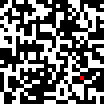

In [47]:
_ = day10_part2(puzzle.input, visualize=True)

<a name="day11"></a>
## Day 11: Turtle walk painting

The given Intcode program lets a painting robot traverses a 2D grid.
It successively reads the current color, emits a paint color (`0`: black, `1`: white) and rotation (`0`: left, `1`: right) and then move forward.

- Part 1: Report the number of panels painted at least once.

- Part 2: Change the color of the starting tile to white and run again.  Report the drawn text message.

In [48]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2019/day/11), `puzzle.input` has a single line of 2_051 characters:

3,8,1005,8,319,1106,0,11,0,0,0,104,1,104,0,3,8,1002,8,-1,10,101,1,10,10,4,10,108 ... 1,-2,22201,-4,-2,-4,109,-5,2105,1,0


The stored answers are: `{1: '1985', 2: 'BLCZCJLZ'}`

In [49]:
def day11(s, *, part2=False, visualize_nth=0):

  class Painter:

    def __init__(self, visualize_nth=0):
      self.painted = {}  # (y, x) -> value 0 or 1
      self.yx = 0, 0  # position (initially at origin)
      self.dyx = -1, 0  # direction (initially up)
      self.visualize_nth = visualize_nth
      self.num_paints = 0
      self.num_frames = 0
      self.tyx_white = set()

    def paint_color(self, color):
      self.painted[self.yx] = color
      if self.visualize_nth and (self.num_paints < self.visualize_nth or
                                 self.num_paints % self.visualize_nth == 0):
        self.tyx_white.update((self.num_frames, *yx)
                              for yx, value in self.painted.items() if value)
        self.num_frames += 1
      self.num_paints += 1

    def advance(self, turn):  # 0=left, 1=right
      self.dyx = ((self.dyx[1], -self.dyx[0]) if turn else
                  (-self.dyx[1], self.dyx[0]))
      self.yx = self.yx[0] + self.dyx[0], self.yx[1] + self.dyx[1]

    def current_color(self):
      return self.painted.get(self.yx, 0)

    def num_painted(self):
      return len(self.painted)

    def visualized_grid(self):
      indices = {yx for yx, value in self.painted.items() if value == 1}
      return hh.grid_from_indices(indices, dtype=np.uint8, pad=0)

    def finish(self):
      if self.visualize_nth:
        video: Any = hh.grid_from_indices(self.tyx_white, pad=(0, 1, 1), dtype=bool)
        video = video.repeat(2, axis=1).repeat(2, axis=2)
        video = [video[0]] * 25 + list(video) + [video[-1]] * 25
        media.show_video(video, codec='gif', fps=50)

  def test():
    small = [
        (1, 0),  # paint white, turn left, advance W
        (0, 0),  # paint black, turn left, advance S
        (1, 0),  # paint white, turn left, advance E
        (1, 0),  # paint white, turn left, advance N
        (0, 1),  # paint black, turn right, advance E
        (1, 0),  # paint white, turn left, advance N
        (1, 0),  # paint white, turn left, advance W
    ]
    painter = Painter()  # visualize_nth=1
    for color, turn in small:
      painter.paint_color(color)
      painter.advance(turn)
    painter.finish()
    check_eq(painter.num_painted(), 6)

  test()

  machine = Machine.make(s)
  painter = Painter(visualize_nth=visualize_nth)
  initial_color = 1 if part2 else 0
  painter.paint_color(initial_color)
  check_eq(machine.run_until_need_input([]), [])
  while not machine.terminated:
    color, turn = machine.run_until_need_input([painter.current_color()])
    painter.paint_color(color)
    painter.advance(turn)

  painter.finish()
  if not part2:
    return painter.num_painted()

  grid = painter.visualized_grid()
  s2 = hh.string_from_grid(grid, {0: '.', 1: '#'})
  if not visualize_nth:
    hh.display_html(s2.replace('.', '⬜').replace('#', '⬛').replace('\n', '<br/>'))
  return advent_of_code_ocr.convert_6(s2)  # e.g. 'BLCZCJLZ'


puzzle.verify(1, day11)  # ~50 ms with NumbaMachine; ~400 ms without.

day11_part2 = functools.partial(day11, part2=True)
puzzle.verify(2, day11_part2)  # ~10 ms with NumbaMachine; ~40 ms without.

(Part 1: 0.016 s)
(Part 2: 0.001 s)


""

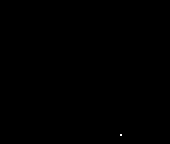

""


In [50]:
_ = day11(puzzle.input, visualize_nth=8)
_ = day11_part2(puzzle.input, visualize_nth=1)

<a name="day12"></a>
## Day 12: Periodic n-body problem

Given initial positions for a set of 4 moons in a 3D integer lattice, simulate their motions, where the inter-moon gravitational force for each coordinate equals the sign of the position difference.

- Part 1: Compute the sum of "potential" and "kinetic" energies after 1000 simulation steps.

- Part 2: Report the number of simulation steps before all positions and velocities repeat.

In [18]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2019/day/12), `puzzle.input` has 4 lines:

<x=-6, y=2, z=-9>
<x=12, y=-14, z=-4>
<x=9, y=5, z=-6>
<x=-1, y=-4, z=9>


The stored answers are: `{1: '14907', 2: '467081194429464'}`

In [19]:
s1 = """\
<x=-1, y=0, z=2>
<x=2, y=-10, z=-7>
<x=4, y=-8, z=8>
<x=3, y=5, z=-1>
"""

# long period
s2 = """\
<x=-8, y=-10, z=0>
<x=5, y=5, z=10>
<x=2, y=-7, z=3>
<x=9, y=-8, z=-3>
"""

In [22]:
def day12(s, *, num_steps=1000, verbose=False):
  position = np.array(re.findall(r'<x=(.*), y=(.*), z=(.*)>', s), np.int64)
  velocity = np.full_like(position, 0)

  for step in range(num_steps):
    all_vectors = position[:, None] - position  # [n, n, 3]
    acceleration = np.sign(all_vectors).sum(axis=0)
    velocity += acceleration
    position += velocity
    if verbose:
      print(f'After {step + 1} steps:')
      for p, v in zip(position, velocity):
        print(f'pos=<x={p[0]:3}, y={p[1]:3}, z={p[2]:3}>, '
              f'vel=<x={v[0]:3}, y={v[1]:3}, z={v[2]:3}>')

  potential = abs(position).sum(axis=-1)
  kinetic = abs(velocity).sum(axis=-1)
  grand_total = (potential * kinetic).sum()
  return grand_total


check_eq(day12(s1, num_steps=10), 179)
check_eq(day12(s2, num_steps=100), 1940)
puzzle.verify(1, day12)  # ~9 ms.

(Part 1: 0.004 s)


Note that the mathematical operations are independent for `x`, `y`, and `z` coordinates.
Therefore we can separately compute the period for each coordinate and then take the least
common multiple of the three periods.

Could there may be some transient behavior at the start of the simulation?  No, all the
detected periods start at the initial step=0.

In [23]:
@numba.njit
def day12_period_for_1d(initial_position):
  position = initial_position.copy()
  velocity = np.full_like(position, 0)
  n = len(position)
  for step in range(1, sys.maxsize):  # numba does not recognize "itertools.count(1)".
    for i in range(n):
      for j in range(n):
        diff = position[j] - position[i]
        velocity[i] += 1 if diff > 0 else -1 if diff < 0 else 0
    position += velocity
    if np.all(velocity == 0.0) and np.all(position == initial_position):
      return step


def day12_part2(s):

  # ~8 s without numba.
  def period_for_1d(initial_position):
    position = initial_position.copy()
    velocity = np.full_like(position, 0)
    step = 0
    while True:
      step += 1
      # (Note that "position[:, None]" is not supported in numba)
      all_vectors = position.reshape(-1, 1) - position
      acceleration = np.sign(all_vectors).sum(axis=0)
      velocity += acceleration
      position += velocity
      if np.all(velocity == 0.0) and np.all(position == initial_position):
        return step

  # ~72 ms with numba; ~20 s without numba.
  if using_numba:
    period_for_1d = day12_period_for_1d  # noqa

  initial_position = np.array(re.findall(r'<x=(.*), y=(.*), z=(.*)>', s), np.int64)
  periods = [period_for_1d(initial_position[:, coord]) for coord in range(3)]
  return np.lcm.reduce(periods)


check_eq(day12_part2(s1), 2772)
check_eq(day12_part2(s2), 4686774924)

# ~72 ms with numba; ~8 s without numba.
puzzle.verify(2, day12_part2)

(Part 2: 0.020 s)


<a name="day13"></a>
## Day 13: Game with ball and paddle

Given an Intcode program simulating a game, where the output is a sequence of `x, y, tile_id` screen updates:

- Part 1: Report the number of block tiles on screen when the game exits

- Part 2: Control a joystick using (`-1`: left, `0`: center, `1`: right) inputs, and report the score (at screen `x=-1, y=0)` after winning the game by breaking all the blocks.

In [55]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2019/day/13), `puzzle.input` has a single line of 8_045 characters:

1,380,379,385,1008,2979,673982,381,1005,381,12,99,109,2980,1102,0,1,383,1101,0,0 ... ,98,3,93,65,63,53,23,7,37,63,673982


The stored answers are: `{1: '306', 2: '15328'}`

In [56]:
# 0 is an empty tile. No game object appears in this tile.
# 1 is a wall tile. Walls are indestructible barriers.
# 2 is a block tile. Blocks can be broken by the ball.
# 3 is a horizontal paddle tile. The paddle is indestructible.
# 4 is a ball tile. The ball moves diagonally and bounces off objects.

In [57]:
def day13(s):
  grid = {}
  for x, y, tile_id in more_itertools.chunked(Machine.make(s).run_fully(), 3):
    grid[y, x] = tile_id

  if 0:
    with np.printoptions(linewidth=1000, threshold=100_000):
      print(hh.grid_from_indices(grid))

  return sum(value == 2 for value in grid.values())  # num tiles left on screen


puzzle.verify(1, day13)  # ~3 ms with NumbaMachine; ~80 ms without.

(Part 1: 0.001 s)


In [58]:
def day13_part2(s, *, visualize=False):
  machine = Machine.make(s)
  machine.mem[0] = 2  # set free play
  score = None
  grid = {}
  last_yx = {}
  input: list[int] = []

  images: list[np.ndarray] = []
  while not machine.terminated:
    output = machine.run_until_need_input(input)
    for x, y, tile_id in more_itertools.chunked(output, 3):
      assert x is not None and y is not None and tile_id is not None  # Help mypy.
      if (x, y) == (-1, 0):
        score = tile_id
      else:
        grid[y, x] = tile_id
        if tile_id in (4, 3):  # ball or paddle
          last_yx[tile_id] = y, x
    input = [np.sign(last_yx[4][1] - last_yx[3][1])]  # ball.x - paddle.x

    if visualize and len(images) < 600:
      cmap = {0: (0,) * 3, 1: (50,) * 3, 2: (160,) * 3, 3: (250, 250, 50), 4: (255, 100, 100)}
      image = hh.image_from_yx_map(grid, background=0, cmap=cmap)
      image = image.repeat(4, axis=1).repeat(4, axis=0)
      images.append(image)

  if visualize:
    images = [images[0]] * 50 + images + [images[-1]] * 50
    media.show_video(images, codec='gif', fps=50)

  return score


puzzle.verify(2, day13_part2)  # ~65 ms with NumbaMachine; ~3 s without.

(Part 2: 0.031 s)


""

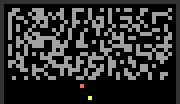

In [59]:
_ = day13_part2(puzzle.input, visualize=True)

<a name="day14"></a>
## Day 14: Make fuel from ore

Given a list of reactions (integer count of input chemicals necessary to produce count of one output chemical):

- Part 1: Report the amount of `ORE` required to produce 1 `FUEL`.

- Part 2: Given 1 trillion `ORE`, report the maximum amount of `FUEL` that can be produced.

In [60]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2019/day/14), `puzzle.input` has 58 lines:

1 JKXFH => 8 KTRZ
11 TQGT, 9 NGFV, 4 QZBXB => 8 MPGLV
8 NPDPH, 1 WMXZJ => 7 VCNSK
1 MPGLV, 6 CWHX => 5 GDRZ
16 JDFQZ => 2 CJTB
1 GQNQF, 4 JDFQZ => 5 WJKDC
2 TXBS, 4 SMGQW, 7 CJTB, 3 NTBQ, 13 CWHX, 25 FLPFX => 1 FUEL
3 WMXZJ, 14 CJTB => 5 FLPFX
 ...
7 KWCDP => 3 SCKB
6 LGKHR => 8 MKLP
39 MKJDZ => 9 CZSJ
2 TSWN, 1 WMXZJ => 3 PSJL


The stored answers are: `{1: '2486514', 2: '998536'}`

In [61]:
s1 = """\
10 ORE => 10 A
1 ORE => 1 B
7 A, 1 B => 1 C
7 A, 1 C => 1 D
7 A, 1 D => 1 E
7 A, 1 E => 1 FUEL
"""

s2 = """\
9 ORE => 2 A
8 ORE => 3 B
7 ORE => 5 C
3 A, 4 B => 1 AB
5 B, 7 C => 1 BC
4 C, 1 A => 1 CA
2 AB, 3 BC, 4 CA => 1 FUEL
"""

s3 = """\
157 ORE => 5 NZVS
165 ORE => 6 DCFZ
44 XJWVT, 5 KHKGT, 1 QDVJ, 29 NZVS, 9 GPVTF, 48 HKGWZ => 1 FUEL
12 HKGWZ, 1 GPVTF, 8 PSHF => 9 QDVJ
179 ORE => 7 PSHF
177 ORE => 5 HKGWZ
7 DCFZ, 7 PSHF => 2 XJWVT
165 ORE => 2 GPVTF
3 DCFZ, 7 NZVS, 5 HKGWZ, 10 PSHF => 8 KHKGT
"""

s4 = """\
2 VPVL, 7 FWMGM, 2 CXFTF, 11 MNCFX => 1 STKFG
17 NVRVD, 3 JNWZP => 8 VPVL
53 STKFG, 6 MNCFX, 46 VJHF, 81 HVMC, 68 CXFTF, 25 GNMV => 1 FUEL
22 VJHF, 37 MNCFX => 5 FWMGM
139 ORE => 4 NVRVD
144 ORE => 7 JNWZP
5 MNCFX, 7 RFSQX, 2 FWMGM, 2 VPVL, 19 CXFTF => 3 HVMC
5 VJHF, 7 MNCFX, 9 VPVL, 37 CXFTF => 6 GNMV
145 ORE => 6 MNCFX
1 NVRVD => 8 CXFTF
1 VJHF, 6 MNCFX => 4 RFSQX
176 ORE => 6 VJHF
"""

s5 = """\
171 ORE => 8 CNZTR
7 ZLQW, 3 BMBT, 9 XCVML, 26 XMNCP, 1 WPTQ, 2 MZWV, 1 RJRHP => 4 PLWSL
114 ORE => 4 BHXH
14 VRPVC => 6 BMBT
6 BHXH, 18 KTJDG, 12 WPTQ, 7 PLWSL, 31 FHTLT, 37 ZDVW => 1 FUEL
6 WPTQ, 2 BMBT, 8 ZLQW, 18 KTJDG, 1 XMNCP, 6 MZWV, 1 RJRHP => 6 FHTLT
15 XDBXC, 2 LTCX, 1 VRPVC => 6 ZLQW
13 WPTQ, 10 LTCX, 3 RJRHP, 14 XMNCP, 2 MZWV, 1 ZLQW => 1 ZDVW
5 BMBT => 4 WPTQ
189 ORE => 9 KTJDG
1 MZWV, 17 XDBXC, 3 XCVML => 2 XMNCP
12 VRPVC, 27 CNZTR => 2 XDBXC
15 KTJDG, 12 BHXH => 5 XCVML
3 BHXH, 2 VRPVC => 7 MZWV
121 ORE => 7 VRPVC
7 XCVML => 6 RJRHP
5 BHXH, 4 VRPVC => 5 LTCX
"""

In [62]:
def day14(s, *, fuel=1):

  def parse_recipes(s):
    """Returns {output: (quantity_output, Counter(inputs)}."""

    def element_quantity(s):
      quantity, element = hh.re_groups(r'^(\d+) (\w+)$', s)
      return collections.Counter({element: int(quantity)})

    lines = s.splitlines()
    recipes = {}
    for line in lines:
      s_input, s_output = hh.re_groups(r'^([^=]+) => (\d+ \w+)$', line)
      input_counters = (element_quantity(s) for s in s_input.split(', '))
      input_counter = functools.reduce(lambda a, b: a + b, input_counters)
      (output_element, quantity_output), = element_quantity(s_output).items()
      recipes[output_element] = quantity_output, input_counter
    return recipes

  Counter = collections.Counter
  inputs = Counter({'FUEL': fuel})
  recipes = parse_recipes(s)
  graph = {node: list(counter) for node, (_, counter) in recipes.items()}
  graph['ORE'] = []
  elements_in_order = hh.topological_sort(graph)
  check_eq(elements_in_order[0], 'FUEL')
  check_eq(elements_in_order.pop(), 'ORE')
  for element_needed in elements_in_order:
    quantity_needed = inputs.pop(element_needed)
    quantity_generated, input_counter = recipes[element_needed]
    factor = math.ceil(quantity_needed / quantity_generated)
    inputs += Counter({k: factor * v for k, v in input_counter.items()})
  check_eq(len(inputs), 1)
  quantity = inputs.pop('ORE')
  return quantity


check_eq(day14(s1), 31)
check_eq(day14(s2), 165)
check_eq(day14(s3), 13312)
check_eq(day14(s4), 180697)
check_eq(day14(s5), 2210736)

puzzle.verify(1, day14)  # ~2 ms.

(Part 1: 0.001 s)


In [63]:
def day14_part2(s, *, debug=False):

  def ore_from_fuel(fuel):
    return day14(s, fuel=fuel)

  ore_bound = 1_000_000_000_000
  fuel = hh.discrete_binary_search(ore_from_fuel, 0, 10_000_000, ore_bound)
  if debug:
    assert ore_bound - 1_000_000 <= ore_from_fuel(fuel) < ore_bound
  return fuel

puzzle.verify(2, day14_part2)  # ~43 ms.
_ = day14_part2(puzzle.input, debug=True)

(Part 2: 0.017 s)


<a name="day15"></a>
## Day 15: Shortest maze path

Given a program controlling a robot, which accepts movement commands (`1`: north, `2`: south, `3`: west, `4`: east) and outputs status (`0`: hit wall, `1`: moved, `2`: reached destination):

- Part 1: Report the fewest number of movement commands to reach the destination.

- Part 2: Simulate oxygen spreading from destination at a speed of one cell per minute.  report the number of minutes to fill all cells.

In [64]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2019/day/15), `puzzle.input` has a single line of 3_341 characters:

3,1033,1008,1033,1,1032,1005,1032,31,1008,1033,2,1032,1005,1032,58,1008,1033,3,1 ... ,31,63,0,0,21,21,1,10,1,0,0,0,0,0,0


The stored answers are: `{1: '218', 2: '544'}`

In [65]:
class Day15ExploreMaze:
  ORIGIN = 0, 0  # yx
  NEIGHBORS = (0, 1), (1, 0), (0, -1), (-1, 0)

  # north (1), south (2), west (3), and east (4)
  COMMAND_FOR_MOVEMENT = {(0, 1): 4, (1, 0): 2, (0, -1): 3, (-1, 0): 1}

  def __init__(self, machine_s):
    self.machine = Machine.make(machine_s)
    self.grid = {}  # {yx: code} with code in '.#' (empty, wall)
    self.current_yx = self.ORIGIN
    self.grid[self.current_yx] = '.'  # empty
    self.destination: tuple[int, int] | None = None  # not yet found

  def shortest_path(self, src_yx, until='unknown'):
    # Performs a breadth-first search in the known grid from src_yx until either
    # reaching an unknown node or reaching the destination (based on 'until').
    # Returns a list of yx coordinates along the path (not including src_yx),
    # or [] if the search terminates.
    assert until in ('unknown', 'destination')
    seen = {src_yx}
    to_visit = collections.deque([src_yx])
    previous: dict[tuple[int, int], tuple[int, int]] = {}  # {yx: node_yx_which_saw_it}

    while to_visit:
      yx = to_visit.popleft()
      if ((until == 'destination' and yx == self.destination) or
          (until == 'unknown' and yx not in self.grid)):
        path = [yx]
        while yx in previous:
          yx = previous[yx]
          path.append(yx)
        return path[-2::-1]  # omit src_yx
      for neighbor in self.NEIGHBORS:
        yx2 = yx[0] + neighbor[0], yx[1] + neighbor[1]
        if yx2 not in seen and self.grid.get(yx2) != '#':
          seen.add(yx2)
          to_visit.append(yx2)
          previous[yx2] = yx

    return []

  def advance_to(self, yx):
    diff = yx[0] - self.current_yx[0], yx[1] - self.current_yx[1]
    command = self.COMMAND_FOR_MOVEMENT[diff]
    result, = self.machine.run_until_need_input([command])
    assert 0 <= result <= 2
    if result == 0:  # wall
      assert yx not in self.grid
      self.grid[yx] = '#'  # wall
      return False
    self.current_yx = yx
    self.grid[yx] = '.'  # empty
    if result == 2:  # found destination
      self.destination = yx
    return True

  def explore(self):
    while path := self.shortest_path(self.current_yx, until='unknown'):
      for yx in path[:-1]:
        check_eq(self.advance_to(yx), True)
      self.advance_to(path[-1])

  def visualize_grid(self, grid):
    g = grid.copy()
    g[self.ORIGIN] = 'S'
    if self.destination:
      g[self.destination] = 'D'
    # g[self.current_yx] = '@'
    cmap = {
        ' ': (235,) * 3,
        '.': (190,) * 3,
        '#': (20,) * 3,
        'S': (0, 255, 0),
        'D': (255, 0, 0),
        '@': (255, 255, 100),
        'p': (0, 255, 255),
    }
    image = hh.image_from_yx_map(g, background=' ', cmap=cmap, pad=1)
    return image.repeat(4, axis=0).repeat(4, axis=1)

  def compute(self, visualize=False):
    self.explore()
    assert self.destination
    path = self.shortest_path(self.ORIGIN, until='destination')
    if visualize:
      grid = self.grid.copy()
      images = []
      for yx in path:
        grid[yx] = 'p'
        images.append(self.visualize_grid(grid))
      images = [images[0]] * 25 + images + [images[-1]] * 25
      media.show_video(images, codec='gif', fps=25)
    return len(path)

  def farthest_distance_from_destination(self, visualize=False):
    self.compute()
    assert self.destination
    src_yx = self.destination
    seen = {src_yx}
    to_visit = collections.deque([src_yx])
    previous = {}  # {yx: node_yx_which_saw_it}

    while to_visit:
      yx = to_visit.popleft()
      for neighbor in self.NEIGHBORS:
        yx2 = yx[0] + neighbor[0], yx[1] + neighbor[1]
        if yx2 not in seen and self.grid.get(yx2) != '#':
          seen.add(yx2)
          to_visit.append(yx2)
          previous[yx2] = yx

    grid = self.grid.copy()
    farthest_yx = yx
    distance = 0
    while yx in previous:
      yx = previous[yx]
      distance += 1
    if visualize:
      images = []
      grid[farthest_yx] = 'D'
      yx = farthest_yx
      while yx in previous:
        grid[yx] = 'p'
        yx = previous[yx]
        images.append(self.visualize_grid(grid))
      images = [images[0]] * 25 + images + [images[-1]] * 25
      media.show_video(images, codec='gif', fps=25)
    return distance


def day15(s):
  return Day15ExploreMaze(s).compute()

puzzle.verify(1, day15)  # ~32 ms.

(Part 1: 0.013 s)


""

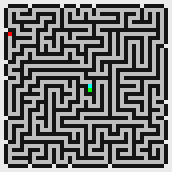

In [66]:
_ = Day15ExploreMaze(puzzle.input).compute(visualize=True)

In [67]:
def day15_part2(s):
  return Day15ExploreMaze(s).farthest_distance_from_destination()

puzzle.verify(2, day15_part2)  # ~36 ms.

(Part 2: 0.013 s)


""

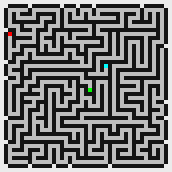

In [68]:
_ = Day15ExploreMaze(puzzle.input).farthest_distance_from_destination(visualize=True)

<a name="day16"></a>
## Day 16: Fast faulty transform (FFT)

Given a list of numbers, FFT applies `k` phases.  In a phase, each element is replaced by a new value which is the dot product of the whole list with a repeating pattern, modulo 10.  To compute element `i`, the pattern is a base pattern `0, 1, 0, -1` in which each element is repeated `i` times, and the very first `0` pattern value is omitted.

- Part 1: report the first 8 digits after 100 phases of FFT.

- Part 2: Repeat the input list 10_000 times.  After 100 phases of FFT, report the 8 digits at an offset specified by the first 7 input digits.

In [69]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2019/day/16), `puzzle.input` has a single line of 650 characters:

59709511599794439805414014219880358445064269099345553494818286560304063399998657 ... 63060659768372996371503017206185697


The stored answers are: `{1: '34841690', 2: '48776785'}`

In [70]:
s1 = '12345678'

In [71]:
def day16_part1(s, *, num_phases=100, debug=False):

  def get_fft_pattern(n, i):
    pattern: Iterable[int] = (0, 1, 0, -1)
    pattern = itertools.cycle(pattern)
    pattern = more_itertools.repeat_each(pattern, i + 1)
    pattern = list(itertools.islice(pattern, 1, n + 1))
    return pattern

  def print_fft_patterns(n):
    with np.printoptions(linewidth=1000, threshold=100_000):
      print(np.array([get_fft_pattern(n, i) for i in range(n)]))

  if debug:
    print_fft_patterns(20)
    return

  l = np.array(list(map(int, s.strip())))
  patterns = np.array([get_fft_pattern(len(l), i) for i in range(len(l))])
  for _ in range(num_phases):
    np.mod(abs(patterns @ l), 10, out=l)
  return ''.join(map(str, map(int, l[:8])))


check_eq(day16_part1(s1, num_phases=4), '01029498')
check_eq(day16_part1(s1, num_phases=100), '23845678')
check_eq(day16_part1('80871224585914546619083218645595'), '24176176')
check_eq(day16_part1('19617804207202209144916044189917'), '73745418')
check_eq(day16_part1('69317163492948606335995924319873'), '52432133')
puzzle.verify(1, day16_part1)  # ~100 ms.

(Part 1: 0.042 s)


Part 2

In [72]:
s2 = '03036732577212944063491565474664'
s3 = '02935109699940807407585447034323'
s4 = '03081770884921959731165446850517'

In [73]:
def day16_test():
  # We notice that the requested offset in the output is always near the end:
  for input in [s2, s3, s4, puzzle.input]:
    index = int(input[:7])
    frac = index / (len(input) * 10_000)
    trailing = len(input) * 10_000 - index
    print(f'{index=:<8} {frac=:#.4} {trailing=}')

if 0:
  day16_test()

In [74]:
# Observation: all the requested output subsequences are near the end,
# where the computations do not involve negative factors!
# Therefore we can work with modulo-10 arithmetic and always consider just
# the trailing digits.

# Observation: we can do the update of each phase using a cumulative sum from
# the rear of the array.  That is efficient enough!
# For 500_000 digits and 100 phases, we can afford to have space complexity
# of 500_000 and time complexity of 50_000_000.

In [75]:
@numba.njit
def day16_fft_transform2_helper(l, num_phases=100):
  mod10 = np.arange(20) % 10
  for _ in range(num_phases):
    total = 0
    for i in range(len(l) - 1, -1, -1):
      # l[i] = total = (l[i] + total) % 10
      l[i] = total = mod10[l[i] + total]

def day16_part2(s, *, repeat_input=10_000):

  def fft_transform2_helper(l, num_phases=100):
    for phase in range(num_phases):
      np.cumsum(l[::-1], out=l[::-1])
      # As an optimization, we skip the mod() operation for 2 phases.
      # (If we skip more than 2 phases, the numbers overflow int64.)
      if phase % 3 == 0:
        np.mod(l, 10, out=l)
    np.mod(l, 10, out=l)

  if using_numba:
    fft_transform2_helper = day16_fft_transform2_helper  # noqa

  index = int(s[:7])
  l = list(map(int, s.strip())) * repeat_input
  assert index > len(l) * 0.51  # output is only valid over last half
  l = np.array(l[index:])  # (Setting dtype has no effect on numba performance.)
  fft_transform2_helper(l)
  return ''.join(map(str, l[:8]))


check_eq(day16_part2(s2), '84462026')
check_eq(day16_part2(s3), '78725270')
check_eq(day16_part2(s4), '53553731')
puzzle.verify(2, day16_part2)  # ~260 ms with numba; ~410 ms without numba.

(Part 2: 0.135 s)


In [76]:
# The following is a failed attempt to derive a closed-form solution.
# Let d(i, k) be the digit at position i from the end after k phases.

# Observation: for the desired k=100, multiplication by k results in a zero
# last digit, so some terms can be ignored?

# d(0, k) = d(0, k-1)
#         = d(0, 0)
# The last digit never changes.

# d(1, k) = d(1, k-1) + d(0, k-1)
#         = d(1, k-1) + d(0, 0)
#         = (d(1, k-2) + d(0, 0)) + d(0, 0)
#         = d(1, 0) + k * d(0, 0)
# The next-to-last digit just adds the last digit k times.

# d(2, k) = d(2, k-1) + d(1, k-1) + d(0, k-1)
#         = d(2, k-1) + (d(1, 0) + (k-1) * d(0, 0)) + d(0, 0)
#         = d(2, k-1) + (d(1, 0) + k * d(0, 0))  YES
#         = d(2, k-1) + d(1, k)  useful?
#    or   = (d(2, k-2) + d(1, k-2) + d(0, k-2)) + (d(1, 0) + k * d(0, 0))
#         = d(2, k-2) + (d(1, 0) + (k-2) * d(0, 0)) + d(0, 0) + d(1, 0) + k * d(0, 0)
#         = d(2, k-2) + 2 * d(1, 0) + (k + k - 1) * d(0, 0)
#         = d(2, 0) + k * d(1, 0) + (k*(k+1)/2) * d(0, 0)

# d(3, k) = d(3, k-1) + d(2, k-1) + d(1, k-1) + d(0, k-1)
#         = d(3, k-1) + (d(2, 0) + (k-1) * d(1, 0) + (k*(k-1)/2) * d(0, 0)) + (d(1, 0) + (k-1) * d(0, 0)) + d(0, 0)
#         = d(3, k-1) + d(2, 0) + k * d(1, 0) + (k+1)*k/2 * d(0, 0)
#         = d(3, 0) + k * d(2, 0) + k*(k+1)/2 * d(1, 0) + E * d(0, 0)
#   where E = (((k+1)*k)/2+1) * (k+1)*k/2) / 2 = (k^4 + 2*k^3 + 3*k^2 + 2*k)/8  yuck

#   0 80871224585914546619083218645595
# 100 24176176480919046114038763195595

<a name="day17"></a>
## Day 17: Robot movement routine

Use the input program to output a 2D map with a self-intersecting scaffold path.

- Part 1: Compute some measurement of the intersections of the 2D path.

- Part 2: Determine the sequence of turn and move instructions for the scaffold path, then encode these into a short routine with instance calls to 3 short subpaths.  Enter the routine and subpaths as input to the program and report some program output.

In [77]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2019/day/17), `puzzle.input` has a single line of 4_943 characters:

1,330,331,332,109,3890,1102,1,1182,16,1102,1471,1,24,101,0,0,570,1006,570,36,100 ... ,36,1,3,1,36,1,3,1,36,1,3,1,36,5,32


The stored answers are: `{1: '7584', 2: '1016738'}`

In [78]:
s1 = """\
..#..........
..#..........
#######...###
#.#...#...#.#
#############
..#...#...#..
..#####...^..
"""

In [79]:
def day17_parse_scaffold_grid(s):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1, '^': 2})
  start, = zip(*np.nonzero(grid == 2))
  return grid, start

def day17_test():
  grid, start = day17_parse_scaffold_grid(s1)
  print(grid, start)

if 0:
  day17_test()

In [80]:
def day17_part1(s):

  def find_intersections(s):
    grid, unused_start = day17_parse_scaffold_grid(s)
    intersections = []
    for y in range(1, grid.shape[0] - 1):
      for x in range(1, grid.shape[1] - 1):
        def f(y, x):
          return grid[y, x] != 0
        if f(y, x) and f(y, x - 1) and f(y, x + 1) and f(y - 1, x) and f(y + 1, x):
          intersections.append((y, x))

    return sum(x * y for y, x in intersections)

  check_eq(find_intersections(s1), 76)

  output = Machine.make(s).run_fully()
  puzzle_s = ''.join(map(chr, output))
  return find_intersections(puzzle_s)


puzzle.verify(1, day17_part1)  # ~3 ms.

(Part 1: 0.002 s)


Part 2

In [81]:
s2 = """\
#######...#####
#.....#...#...#
#.....#...#...#
......#...#...#
......#...###.#
......#.....#.#
^########...#.#
......#.#...#.#
......#########
........#...#..
....#########..
....#...#......
....#...#......
....#...#......
....#####......
"""

In [82]:
def day17_part2(s, *, visualize=False):

  def get_robot_input(s):

    def compute_commands(s):
      grid, start = day17_parse_scaffold_grid(s)
      yx = start
      dyx = -1, 0  # initial direction is up ('^')

      def is_scaffold(yx): return grid[yx] == 1
      def inbounds(yx): return all(0 <= yx[i] < grid.shape[i] for i in range(2))
      def inbound_scaffold(yx): return inbounds(yx) and is_scaffold(yx)
      def turn_left(dyx): return -dyx[1], dyx[0]
      def turn_right(dyx): return dyx[1], -dyx[0]

      assert not is_scaffold(tuple(np.array(yx) + dyx))
      commands = []
      current_forward_steps = 0

      while True:
        yx2 = tuple(np.array(yx) + dyx)
        if inbound_scaffold(yx2):
          current_forward_steps += 1
          yx = yx2
          continue

        if current_forward_steps:
          commands.append(str(current_forward_steps))
        current_forward_steps = 0
        dyx_left = turn_left(dyx)
        yx2 = tuple(np.array(yx) + dyx_left)
        left_ok = inbound_scaffold(yx2)

        dyx_right = turn_right(dyx)
        yx2 = tuple(np.array(yx) + dyx_right)
        right_ok = inbound_scaffold(yx2)
        if not left_ok and not right_ok:
          break
        assert not (left_ok and right_ok)
        dyx = (turn_left if left_ok else turn_right)(dyx)
        commands.append('L' if left_ok else 'R')
      return commands

    check_eq(','.join(compute_commands(s2)),
             'R,8,R,8,R,4,R,4,R,8,L,6,L,2,R,4,R,4,R,8,R,8,R,8,L,6,L,2')

    puzzle_s = ''.join(map(chr, Machine.make(s).run_fully()))
    commands = compute_commands(puzzle_s)
    s_routine = ','.join(commands) + ','
    s_functions: list[str] = []
    for i in range(3):
      # Skip prefix of '([ABC],)*' and minimize resulting string length.
      skip = len(hh.re_groups(r'^(([ABC],)*)', s_routine)[0])
      best = 10**8, '', ''
      for num_matches in range(2, 10):
        pattern = r'([LR0-9][LR,0-9]+[LR0-9],)' + r'.*\1' * num_matches
        if match := re.search(pattern, s_routine[skip:]):
          group1 = match.group(1)[:-1]
          candidate = s_routine.replace(group1, chr(ord('A') + i))
          best = min(best, (len(candidate), group1, candidate))
      _, group1, candidate = best
      s_functions.append(group1)
      s_routine = candidate
      # hh.show(skip, group1, candidate, s_routine)
    s_routine = s_routine[:-1]  # Remove trailing comma.
    assert not any(s in s_routine for s in 'LR')
    if 0:
      hh.show(s_functions, s_routine)

    s_video_feed = 'n'
    return list(more_itertools.flatten(list(map(ord, s + '\n'))
                                       for s in ([s_routine] + s_functions + [s_video_feed])))

  robot_input = get_robot_input(s)
  machine = Machine.make(s)
  check_eq(machine.mem[0], 1)
  machine.mem[0] = 2
  output = machine.run_fully(robot_input)
  if visualize:
    s = ''.join(map(chr, output[:-1]))
    s = s.split('Continuous video feed?')[1].strip('\n')
    # print(s)  # Map confirming that we have reached the end of the path.
    image = (hh.grid_from_string(s) != '.').repeat(3, axis=0).repeat(3, axis=1)
    media.show_image(~image, border=True)
  return output[-1]  # result is the last output element


puzzle.verify(2, day17_part2)  # ~9 ms.

(Part 2: 0.008 s)


""

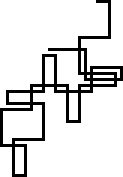

In [83]:
_ = day17_part2(puzzle.input, visualize=True)

<a name="day18"></a>
## Day 18: Maze with doors and keys

Given a 2D maze with gates and keys, with the property that one may pass a gate only if holding its associated key:

- Part 1: Compute the number of steps for the shortest path that collects all the keys.

In [84]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2019/day/18), `puzzle.input` has 81 lines:

#################################################################################
#.....#.....#z#...C.....#.........#.....#.#.....#.......V.#.....#.........#b....#
###.#.###.#.#.#.#####.###.#.#######.###.#.#.#.#.#.#######.#####.#.#######.#.#.###
#...#..y..#.#.#.#...#.#...#........p#...#...#.#...#.....#.#...T.#...#...#...#...#
#.#.#######.#.#.#.###.#.#############.#.#####.#####.#####.#.#.###.###.#.#.#####H#
#.#.#.....#.#.#.#...#...#..l....#.....#.#...Y.#...#.......#.#.#...#...#.#.....#.#
#.#.#.###.#.#.#.###.#####.###.###.#####.#.#####.###.#######.###.###.###.#######.#
#.#.#.G.#.#...#...#.........#...#.#.....#.#...#...#.#.#.........#...#.#...#.....#
 ...
#...#...#.#...#...#.#.#...#.#...#...#.#.#.....#.......#...#...#.#...#.#.....#...#
#.###.###.#.#.#####.#.###.#.#.#.#####.#.#.#######.###.#.#####.#.#.#.###.###.###.#
#.....#.....#.......#...#...#.#.........#.....U...#.....#.....#...#....h#.......#
#################################################################################


The stored answers are: `{1: '4700', 2: '2260'}`

In [85]:
if 0:
  media.set_max_output_height(3000)
  print(puzzle.input)

In [86]:
s1 = """\
#########
#b.A.@.a#
#########
"""

s2 = """\
########################
#f.D.E.e.C.b.A.@.a.B.c.#
######################.#
#d.....................#
########################
"""

s3 = """\
########################
#...............b.C.D.f#
#.######################
#.....@.a.B.c.d.A.e.F.g#
########################
"""

s4 = """\
#################
#i.G..c...e..H.p#
########.########
#j.A..b...f..D.o#
########@########
#k.E..a...g..B.n#
########.########
#l.F..d...h..C.m#
#################
"""

s5 = """\
########################
#@..............ac.GI.b#
###d#e#f################
###A#B#C################
###g#h#i################
########################
"""

s11 = """\
#######
#a.#Cd#
##...##
##.@.##
##...##
#cB#Ab#
#######
"""

s12 = """\
###############
#d.ABC.#.....a#
######@#@######
###############
######@#@######
#b.....#.....c#
###############
"""

s13 = """\
#############
#DcBa.#.GhKl#
#.###@#@#I###
#e#d#####j#k#
###C#@#@###J#
#fEbA.#.FgHi#
#############
"""

s14 = """\
#############
#g#f.D#..h#l#
#F###e#E###.#
#dCba@#@BcIJ#
#############
#nK.L@#@G...#
#M###N#H###.#
#o#m..#i#jk.#
#############
"""

In [87]:
def day18a(s):  # Most compact, for part 1 only
  def is_key(ch): return ch.islower() or ch == '@'
  def is_door(ch): return ch.isupper()
  def key_for_door(ch): return ch.lower()
  grid = hh.grid_from_string(s)
  yx_of_key = {ch: yx for yx, ch in np.ndenumerate(grid) if is_key(ch)}
  current_key = '@'

  @functools.lru_cache(maxsize=None)
  def possible_paths(current_key):  # Returns [(key, distance, needed)].
    yx = yx_of_key[current_key]
    needed: list[str] = []
    to_visit = collections.deque([(0, yx, needed)])
    seen = {yx}
    result = []
    while to_visit:
      distance, yx, needed = to_visit.popleft()
      ch = grid[yx]
      if is_key(ch) and ch != current_key:
        result.append((ch, distance, frozenset(needed)))
        needed = needed + [ch]
      elif is_door(ch):
        needed = needed + [key_for_door(ch)]
      for dy, dx in ((0, 1), (0, -1), (1, 0), (-1, 0)):
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in seen:
          seen.add(yx2)
          to_visit.append((distance + 1, yx2, needed))
    return result

  @functools.lru_cache(maxsize=None)
  def eligible_paths(current_key, keys):  # Returns [(distance, key)].
    return [(d, key) for key, d, needed in possible_paths(current_key)
            if key not in keys and needed.issubset(keys)]

  @functools.lru_cache(maxsize=None)
  def explore(current_key, keys):  # Returns distance.
    if len(keys) == len(yx_of_key):
      return 0
    return min(path_distance + explore(key, keys.union(key))
               for path_distance, key in eligible_paths(current_key, keys))

  return explore(current_key, frozenset(current_key))


check_eq(day18a(s1), 8)  # ~0 ms.
check_eq(day18a(s2), 86)  # ~1 ms.
check_eq(day18a(s3), 132)  # ~1 ms.
check_eq(day18a(s4), 136)  # ~660 ms.
check_eq(day18a(s5), 81)  # ~2 ms.
puzzle.verify(1, day18a)  # ~1100 ms.

(Part 1: 0.146 s)


In [88]:
def day18(s, *, part2=False, visualize=False, fps=50, size=4, speed=1, tail=1):
  def is_key(ch): return ch.islower() or ch in '0123'
  def is_door(ch): return ch.isupper()
  def key_for_door(ch): return ch.lower()
  grid = hh.grid_from_string(s)
  if part2 and np.sum(grid == '@') == 1:
    (y, x), = np.argwhere(grid == '@')
    assert np.all(grid[[y, y, y-1, y+1], [x-1, x+1, x, x]] == '.')
    grid[[y, y, y, y-1, y+1], [x, x-1, x+1, x, x]] = '#'
    grid[[y-1, y-1, y+1, y+1], [x-1, x+1, x-1, x+1]] = '@'
  current_keys = tuple(str(i) for i in range(np.sum(grid == '@')))
  grid[grid == '@'] = current_keys
  yx_of_key: dict[str, tuple[int, int]] = {
      ch: yx for yx, ch in np.ndenumerate(grid) if is_key(ch)}  # type: ignore[misc]

  @functools.lru_cache(maxsize=None)
  def possible_paths(current_key):  # Returns {key: (distance, needed, path)}.
    yx = yx_of_key[current_key]
    needed: list[str] = []
    to_visit = collections.deque([(0, yx, needed)])
    seen = {yx}
    parent: dict[tuple[int, int], tuple[int, int]] = {}
    result = {}
    while to_visit:
      distance, yx, needed = to_visit.popleft()
      ch = grid[yx]
      if is_key(ch) and ch != current_key:
        path = [yx]
        yx2 = yx
        while yx2 in parent:
          yx2 = parent[yx2]
          path.append(yx2)
        result[ch] = distance, frozenset(needed), path[::-1]
        needed = needed + [ch]
      elif is_door(ch):
        needed = needed + [key_for_door(ch)]
      for dy, dx in ((0, 1), (0, -1), (1, 0), (-1, 0)):
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in seen:
          seen.add(yx2)
          parent[yx2] = yx
          to_visit.append((distance + 1, yx2, needed))
    return result

  @functools.lru_cache(maxsize=None)
  def eligible_paths(current_key, keys):  # Returns [(distance, key)].
    items = possible_paths(current_key).items()
    return [(d, key) for key, (d, needed, _) in items
            if key not in keys and needed.issubset(keys)]

  @functools.lru_cache(maxsize=None)
  def move(current_keys, i, key):
    t = list(current_keys)
    t[i] = key
    return tuple(t)

  @functools.lru_cache(maxsize=None)
  def explore(current_keys, keys):  # Returns (distance, index_key, next_key).
    if len(keys) == len(yx_of_key):
      return 0, '', ''
    best = 10**8, -1, ''
    for index_key, current_key in enumerate(current_keys):
      for path_distance, key in eligible_paths(current_key, keys):
        current_keys2 = move(current_keys, index_key, key)
        keys2 = keys.union(key)
        candidate_distance = path_distance + explore(current_keys2, keys2)[0]
        if candidate_distance < best[0]:
          best = candidate_distance, index_key, key
    return best

  distance, _, _ = explore(current_keys, frozenset(current_keys))

  if visualize:
    grid[(grid >= '0') & (grid <= '9')] = '.'
    cmap = {'.': (240,) * 3, '#': (40,) * 3,
            **{chr(ch): (255, 0, 0) for ch in range(ord('a'), ord('z') + 1)},
            **{chr(ch): (0, 180, 0) for ch in range(ord('A'), ord('Z') + 1)}}
    images = []
    keys = frozenset(current_keys)
    owned_key_color = 255, 160, 160
    active_color = 250, 120, 0
    while True:
      image = np.array([cmap[e] for e in grid.flat], np.uint8).reshape(*grid.shape, 3)
      for key in keys.difference('0123'):
        image[yx_of_key[key]] = owned_key_color
      for key in current_keys:
        image[yx_of_key[key]] = active_color
      for yx, ch in np.ndenumerate(grid):
        if is_door(ch) and key_for_door(ch) in keys:
          image[yx] = 130, 255, 130  # Opened door.
      distance, index_key, key = explore(current_keys, keys)
      if distance == 0:
        images.append(image.repeat(size, axis=0).repeat(size, axis=1))
        break
      keys = keys.union(key)
      src_key, dst_key = current_keys[index_key], key
      path = possible_paths(src_key)[dst_key][2]
      image[path[0]] = owned_key_color
      for i, yx in enumerate(path):
        if grid[yx] == '.':
          image[yx] = active_color
        if i >= tail:
          yx = path[i - tail]
          if grid[yx] == '.':
            image[path[i - tail]] = cmap['.']
        if (i - 1) % speed == 0:
          images.append(image.repeat(size, axis=0).repeat(size, axis=1))
      current_keys = move(current_keys, index_key, key)

    images = [images[0]] * (2 * fps) + images + [images[-1]] * (2 * fps)
    media.show_video(images, codec='gif', fps=fps)

  return distance


check_eq(day18(s1), 8)  # ~0 ms.
check_eq(day18(s2), 86)  # ~1 ms.
check_eq(day18(s3), 132)  # ~1 ms.
check_eq(day18(s4), 136)  # ~150 ms.
check_eq(day18(s5), 81)  # ~2 ms.
puzzle.verify(1, day18)  # ~500 ms.

day18_part2 = functools.partial(day18, part2=True)
check_eq(day18_part2(s11), 8)  # ~0 ms.
check_eq(day18_part2(s12), 24)  # ~0 ms.
check_eq(day18_part2(s13), 32)  # ~1 ms.
check_eq(day18_part2(s14), 72)  # ~3 ms.
puzzle.verify(2, day18_part2)  # ~500 ms.

(Part 1: 0.176 s)
(Part 2: 0.216 s)


""


""

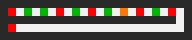

""

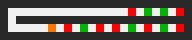

""

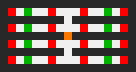

""

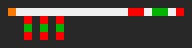

In [89]:
_ = day18(s1, visualize=True, size=8, fps=10)
_ = day18(s2, visualize=True, size=8, fps=10)
_ = day18(s3, visualize=True, size=8, fps=10)
_ = day18(s4, visualize=True, size=8, fps=10)
_ = day18(s5, visualize=True, size=8, fps=10)

""

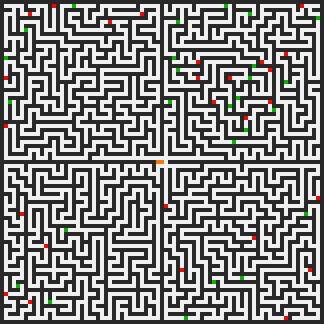

In [90]:
_ = day18(puzzle.input, visualize=True, speed=3, tail=2)  # ~12 s.

""

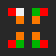

""

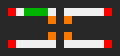

""

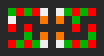

""

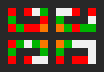

In [91]:
_ = day18_part2(s11, visualize=True, size=8, fps=4)
_ = day18_part2(s12, visualize=True, size=8, fps=4)
_ = day18_part2(s13, visualize=True, size=8, fps=4)
_ = day18_part2(s14, visualize=True, size=8, fps=4)

""

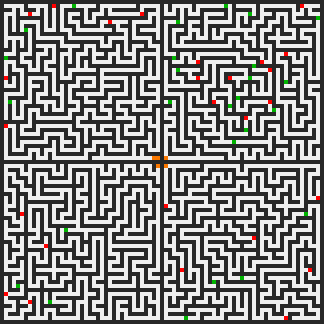

In [92]:
_ = day18_part2(puzzle.input, visualize=True, speed=2, tail=2)  # ~12 s.

<a name="day19"></a>
## Day 19: Tractor beam region

Given a program that reports for a given `(x, y)` points whether a tractor beam is active:

- Part 1: Count the number of points affected by the tractor beam in the square `[0, 49] x [0, 49]`.

- Part 2: Determine the `100x100` square closest to the origin that is entirely within the tractor beam.  Report the upper-left corner `x, y` of the square, as `10_000 * x + y`.

In [93]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2019/day/19), `puzzle.input` has a single line of 1_465 characters:

109,424,203,1,21102,1,11,0,1106,0,282,21101,18,0,0,1105,1,259,2102,1,1,221,203,1 ... 3,-2,1,21201,1,0,-4,109,-5,2106,0,0


The stored answers are: `{1: '169', 2: '7001134'}`

In [94]:
def day19_part1(s, *, shape=(50, 50), visualize=False):

  def in_tractor(y, x):
    output, = Machine.make(s).run_fully([x, y])
    assert output in (0, 1)
    return output == 1

  array = np.fromfunction(np.vectorize(in_tractor), shape)
  if visualize:
    media.show_image(np.pad(array, 1), height=100)
  return np.count_nonzero(array)


puzzle.verify(1, day19_part1)  # ~340 ms with NumbaMachine; ~3400 ms without.

(Part 1: 0.120 s)


""

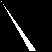

In [95]:
_ = day19_part1(puzzle.input, visualize=True)

In [96]:
def day19_part2(s, *, size=100, visualize=False):

  def in_tractor(y, x):
    output, = Machine.make(s).run_fully([x, y])
    assert output in (0, 1)
    return output == 1

  y = 300
  row_y = np.array([in_tractor(y, x) for x in range(y)])
  xmin, xmax = row_y.nonzero()[0][[0, -1]]  # pylint: disable=unsubscriptable-object
  map_xmax = {}
  yxmap = {(0, 0): 'T'}

  while True:
    y += 1

    # assert not in_tractor(y, xmin - 1)
    while not in_tractor(y, xmin):
      xmin += 1

    # assert in_tractor(y, xmax)
    while in_tractor(y, xmax + 1):
      xmax += 1

    map_xmax[y] = xmax
    yxmap[y, xmin] = yxmap[y, xmax] = '#'

    x_upper_right = map_xmax.get(y - size + 1, 0)
    # print(f'{y=:<6} {xmin=:<6} {xmax=:<6} ur={x_upper_right}')
    if xmin + size - 1 <= x_upper_right:
      x, y = xmin, y - size + 1  # upper-left of square
      if visualize:
        for dy, dx in np.ndindex((size, size)):
          yxmap[y + dy, x + dx] = 'O'
        cmap = {' ': (240,) * 3, 'T': (255, 0, 0), '#': (64,) * 3, 'O': (192,) * 3}
        image = hh.image_from_yx_map(yxmap, background=' ', cmap=cmap, pad=4)
        new_shape = int(image.shape[0] * 0.25), int(image.shape[1] * 0.25)
        image = media.resize_image(image, new_shape)
        media.show_image(image)
      return x * 10_000 + y


puzzle.verify(2, day19_part2)  # ~470 ms with NumbaMachine; ~4.4 s without.

(Part 2: 0.166 s)


""

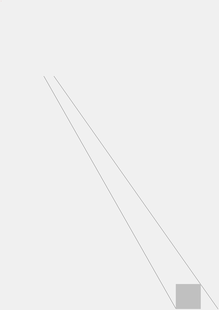

In [97]:
_ = day19_part2(puzzle.input, visualize=True)  # Slow; ~3.8 s.

<a name="day20"></a>
## Day 20: Maze with recursive portals

Given a "donut" maze with portals connecting some inner openings with some outer openings:

- Part 1: Find the length of the shortest path from entrance `AA` to exit `ZZ`.

- Part 2: The maze is recursive.  At the main level, it has no outer openings (other than `AA` and `ZZ`).  At each level, the inner portals connect to the outer portals of a new instance of the maze (at a "deeper level").  Find the path length from `AA` to `ZZ`.

In [98]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2019/day/20), `puzzle.input` has 125 lines:

                                         J       L   P           P   V T       X ...                                    
                                         G       V   M           I   O R       C ...                                    
  #######################################.#######.###.###########.###.#.#######. ... #################################  
  #...#.........#.#...#.#...#.........#.....#.#.....#.......#...#...#.....#.#... ... #...........#.......#...#.......#  
  ###.#########.#.#.###.#.#######.###.###.###.#####.#.###.###.#####.###.###.#### ... ###.#####.###.#.#####.#####.#####  
  #.#.....#...........#...#...#.#.#.....#.....#.#...#.#.....#.#.#.....#.....#... ... #.......#.#...#.....#.#.#.....#.#  
  #.#####.#####.###.#####.###.#.#######.#.#.###.#.#####.###.#.#.#.#########.#.#. ... ###.#######.#.#######.#.###.###.#  
  #...#...#.....#...#.#...#.#.#...#.#.....#.#.......#...#.#.#...#.#.#.......#.#. ... ........#.#.#.........#.#.#.....#  
 ...
  #...............#.....#..

The stored answers are: `{1: '570', 2: '7056'}`

In [99]:
s1 = """\
         A           EOL
         A           EOL
  #######.#########  EOL
  #######.........#  EOL
  #######.#######.#  EOL
  #######.#######.#  EOL
  #######.#######.#  EOL
  #####  B    ###.#  EOL
BC...##  C    ###.#  EOL
  ##.##       ###.#  EOL
  ##...DE  F  ###.#  EOL
  #####    G  ###.#  EOL
  #########.#####.#  EOL
DE..#######...###.#  EOL
  #.#########.###.#  EOL
FG..#########.....#  EOL
  ###########.#####  EOL
             Z       EOL
             Z       EOL
""".replace('EOL', '')

s2 = """\
                   A               EOL
                   A               EOL
  #################.#############  EOL
  #.#...#...................#.#.#  EOL
  #.#.#.###.###.###.#########.#.#  EOL
  #.#.#.......#...#.....#.#.#...#  EOL
  #.#########.###.#####.#.#.###.#  EOL
  #.............#.#.....#.......#  EOL
  ###.###########.###.#####.#.#.#  EOL
  #.....#        A   C    #.#.#.#  EOL
  #######        S   P    #####.#  EOL
  #.#...#                 #......VTEOL
  #.#.#.#                 #.#####  EOL
  #...#.#               YN....#.#  EOL
  #.###.#                 #####.#  EOL
DI....#.#                 #.....#  EOL
  #####.#                 #.###.#  EOL
ZZ......#               QG....#..ASEOL
  ###.###                 #######  EOL
JO..#.#.#                 #.....#  EOL
  #.#.#.#                 ###.#.#  EOL
  #...#..DI             BU....#..LFEOL
  #####.#                 #.#####  EOL
YN......#               VT..#....QGEOL
  #.###.#                 #.###.#  EOL
  #.#...#                 #.....#  EOL
  ###.###    J L     J    #.#.###  EOL
  #.....#    O F     P    #.#...#  EOL
  #.###.#####.#.#####.#####.###.#  EOL
  #...#.#.#...#.....#.....#.#...#  EOL
  #.#####.###.###.#.#.#########.#  EOL
  #...#.#.....#...#.#.#.#.....#.#  EOL
  #.###.#####.###.###.#.#.#######  EOL
  #.#.........#...#.............#  EOL
  #########.###.###.#############  EOL
           B   J   C               EOL
           U   P   P               EOL
""".replace('EOL', '')

s3 = """\
             Z L X W       C                 EOL
             Z P Q B       K                 EOL
  ###########.#.#.#.#######.###############  EOL
  #...#.......#.#.......#.#.......#.#.#...#  EOL
  ###.#.#.#.#.#.#.#.###.#.#.#######.#.#.###  EOL
  #.#...#.#.#...#.#.#...#...#...#.#.......#  EOL
  #.###.#######.###.###.#.###.###.#.#######  EOL
  #...#.......#.#...#...#.............#...#  EOL
  #.#########.#######.#.#######.#######.###  EOL
  #...#.#    F       R I       Z    #.#.#.#  EOL
  #.###.#    D       E C       H    #.#.#.#  EOL
  #.#...#                           #...#.#  EOL
  #.###.#                           #.###.#  EOL
  #.#....OA                       WB..#.#..ZHEOL
  #.###.#                           #.#.#.#  EOL
CJ......#                           #.....#  EOL
  #######                           #######  EOL
  #.#....CK                         #......ICEOL
  #.###.#                           #.###.#  EOL
  #.....#                           #...#.#  EOL
  ###.###                           #.#.#.#  EOL
XF....#.#                         RF..#.#.#  EOL
  #####.#                           #######  EOL
  #......CJ                       NM..#...#  EOL
  ###.#.#                           #.###.#  EOL
RE....#.#                           #......RFEOL
  ###.###        X   X       L      #.#.#.#  EOL
  #.....#        F   Q       P      #.#.#.#  EOL
  ###.###########.###.#######.#########.###  EOL
  #.....#...#.....#.......#...#.....#.#...#  EOL
  #####.#.###.#######.#######.###.###.#.#.#  EOL
  #.......#.......#.#.#.#.#...#...#...#.#.#  EOL
  #####.###.#####.#.#.#.#.###.###.#.###.###  EOL
  #.......#.....#.#...#...............#...#  EOL
  #############.#.#.###.###################  EOL
               A O F   N                     EOL
               A A D   M                     EOL
""".replace('EOL', '')

In [100]:
if 0:
  media.set_max_output_height(3000)
  print(puzzle.input)

In [101]:
def day20(s, *, part2=False, max_level=0, visualize=False, speed=2, repeat=3):

  class Maze:
    NEIGHBORS = (0, 1), (1, 0), (0, -1), (-1, 0)

    def __init__(self, s):
      lines = s.splitlines()
      self.grid = grid = np.array(list(map(list, lines)))
      h, w = grid.shape
      hole = hh.bounding_slices(grid[2:-2, 2:-2] == ' ')
      hole = tuple(slice(s.start + 2, s.stop + 2) for s in hole)

      # [is_inner][name] -> yx
      self.yx_of_portal: dict[int, dict[str, tuple[int, int]]] = {0: {}, 1: {}}
      self.portal_at_yx: dict[tuple[int, int], str] = {}  # [yx] -> name

      def look_for_portal(inner, yx, name):
        if name.isalpha():
          self.portal_at_yx[yx] = name
          assert inner == self.is_inner_portal(yx)
          self.yx_of_portal[inner][name] = yx

      for y in range(h):
        look_for_portal(0, (y, 2), grid[y, 0] + grid[y, 1])
        look_for_portal(0, (y, w - 3), grid[y, w - 2] + grid[y, w - 1])
      for x in range(w):
        look_for_portal(0, (2, x), grid[0, x] + grid[1, x])
        look_for_portal(0, (h - 3, x), grid[h - 2, x] + grid[h - 1, x])
      for y in range(hole[0].start, hole[0].stop):
        x = hole[1].start - 1
        look_for_portal(1, (y, x), grid[y, x + 1] + grid[y, x + 2])
        x = hole[1].stop
        look_for_portal(1, (y, x), grid[y, x - 2] + grid[y, x - 1])
      for x in range(hole[1].start, hole[1].stop):
        y = hole[0].start - 1
        look_for_portal(1, (y, x), grid[y + 1, x] + grid[y + 2, x])
        y = hole[0].stop
        look_for_portal(1, (y, x), grid[y - 2, x] + grid[y - 1, x])

      assert all(name in self.yx_of_portal[0] for name in ('AA', 'ZZ'))
      assert not any(name in self.yx_of_portal[1] for name in ('AA', 'ZZ'))
      assert len(self.yx_of_portal[0]) == len(self.yx_of_portal[1]) + 2
      assert not any(self.is_inner_portal(yx)
                     for yx in self.yx_of_portal[0].values())
      assert all(self.is_inner_portal(yx) for yx in self.yx_of_portal[1].values())

      self.portal_portal_path: dict[
          tuple[int, int], dict[tuple[int, int], list[tuple[int, int]]]] = {}  # [yx][yx2] -> path
      for unused_inner, d in self.yx_of_portal.items():
        for unused_name, src_yx in d.items():
          self.portal_portal_path[src_yx] = self.compute_portal_paths(src_yx)

    def compute_portal_paths(self, src_yx):
      to_visit = collections.deque([src_yx])
      distance = {src_yx: 0}  # for Dijkstra
      parent = {}
      portal_paths: dict[tuple[int, int], list[tuple[int, int]]] = {}  # [yx] -> path

      while to_visit:
        yx = to_visit.popleft()  # Heap not needed because all edge costs are 1.
        for dy, dx in self.NEIGHBORS:
          yx2 = yx[0] + dy, yx[1] + dx
          if yx2 not in distance and self.grid[yx2] == '.':
            distance[yx2] = distance[yx] + 1
            parent[yx2] = yx
            if yx2 in self.portal_at_yx:
              yx3 = yx2
              path = []
              while yx3:
                path.append(yx3)
                yx3 = parent.get(yx3, None)
              portal_paths[yx2] = path[-2::-1]  # Omit src_yx.
            else:
              to_visit.append(yx2)
      return portal_paths

    def is_inner_portal(self, yx) -> int:
      assert yx in self.portal_at_yx
      return int(not any(yx[i] in (2, self.grid.shape[i] - 3) for i in range(2)))

    def opposite_portal(self, lyx, max_level):
      inner = self.is_inner_portal(lyx[1:])
      name = self.portal_at_yx[lyx[1:]]
      yx2 = self.yx_of_portal[1 - inner].get(name)
      l2 = lyx[0] + (0 if max_level == 0 else +1 if inner else -1)
      return (l2, *yx2) if yx2 and 0 <= l2 <= max_level else None

    # Slow version that walks one grid node at a time:
    def shortest_path_old(self, max_level=sys.maxsize):
      src_lyx = (0, *self.yx_of_portal[0]['AA'])  # (level, y, x)
      dst_lyx = (0, *self.yx_of_portal[0]['ZZ'])
      to_visit = collections.deque([src_lyx])
      distance = collections.defaultdict(lambda: sys.maxsize)  # for Dijkstra
      distance[src_lyx] = 0
      parent: dict[tuple[int, int, int], tuple[int, int, int]] = {}

      while to_visit:
        lyx = to_visit.popleft()  # Heap not needed because all edge costs are 1.
        if lyx == dst_lyx:
          path = [lyx]
          while lyx in parent:
            lyx = parent[lyx]
            path.append(lyx)
          return path[-2::-1]  # (The path does not include src_lyx.)
        for dy, dx in self.NEIGHBORS:
          lyx2 = lyx[0], lyx[1] + dy, lyx[2] + dx
          if self.grid[lyx2[1:]].isalpha():
            lyx2 = self.opposite_portal(lyx, max_level)
            if lyx2 is None:
              continue
          elif self.grid[lyx2[1:]] != '.':
            continue
          candidate_d = distance[lyx] + 1
          if candidate_d < distance[lyx2]:
            distance[lyx2] = candidate_d
            parent[lyx2] = lyx
            to_visit.append(lyx2)
      return None  # Could not find path reaching exit.

    # Fast version that jumps across precomputed intra-level shortest paths:
    def shortest_path(self, max_level):
      # Example: https://bradfieldcs.com/algos/graphs/dijkstras-algorithm/
      src_lyx = (0, *self.yx_of_portal[0]['AA'])  # (level, y, x)
      dst_lyx = (0, *self.yx_of_portal[0]['ZZ'])
      pq = [(0, src_lyx)]
      distance = collections.defaultdict(lambda: sys.maxsize)  # for Dijkstra
      distance[src_lyx] = 0
      parent: dict[tuple[int, int, int], tuple[int, int, int]] = {}

      while pq:
        d, lyx = heapq.heappop(pq)
        if lyx == dst_lyx:
          path: list[tuple[int, int, int]] = []
          while lyx in parent:
            lyx2 = parent[lyx]
            if lyx[1:] in self.portal_portal_path[lyx2[1:]]:
              subpath = self.portal_portal_path[lyx2[1:]][lyx[1:]][::-1]
              path.extend((lyx[0], *yx) for yx in subpath)
            else:
              check_eq(self.opposite_portal(lyx2, max_level), lyx)
              path.append(lyx2)
            lyx = lyx2
          return path[::-1]  # (The path does not include src_lyx.)

        # Nodes can get added to the priority queue multiple times.  We only
        # process a node the first time we remove it from the priority queue.
        # However, it has no effect on execution time.
        # if d > distance[lyx]:
        #   continue

        # Consider neighbors within level:
        for yx2, path2 in self.portal_portal_path[lyx[1:]].items():
          lyx2 = (lyx[0], *yx2)
          candidate_d2 = d + len(path2)
          if candidate_d2 < distance[lyx2]:
            distance[lyx2] = candidate_d2
            heapq.heappush(pq, (candidate_d2, lyx2))
            parent[lyx2] = lyx

        # Consider the neighbor across the portal:
        if lyx2 := self.opposite_portal(lyx, max_level):
          candidate_d2 = d + 1
          if candidate_d2 < distance[lyx2]:
            distance[lyx2] = candidate_d2
            heapq.heappush(pq, (candidate_d2, lyx2))
            parent[lyx2] = lyx

      return None  # Could not find path reaching exit.

    def visualize(self, max_level):
      images = []
      src_lyx = (0, *self.yx_of_portal[0]['AA'])
      path = [src_lyx] + self.shortest_path(max_level)
      grid = self.grid.copy()
      grid[('A' <= grid) & (grid <= 'Z')] = 'A'
      cmap = {' ': (235,) * 3, '.': (255,) * 3, '#': (30,) * 3, 'A': (40, 40, 255)}
      image0 = np.array([cmap[e] for e in grid.flat], np.uint8).reshape(
        *grid.shape, 3)

      def record_image(image):
        images.append(image.repeat(repeat, axis=0).repeat(repeat, axis=1))

      image = image0.copy()
      count = 0
      level = 0
      last_lyx = src_lyx
      color = 255, 40, 40
      for lyx in path:
        if lyx[0] == level:
          image[lyx[1:]] = color
          if abs(lyx[1] - last_lyx[1]) + abs(lyx[2] - last_lyx[2]) > 1:
            count = 0  # Jump across portal without level change.
            lyx2 = self.opposite_portal(last_lyx, max_level)
            image[lyx2[1:]] = color
          if count % speed == 0:
            record_image(image)
          count += 1
        else:
          record_image(image)
          image = image0.copy()
          level = lyx[0]
          count = 0
          color = (255, 40, 40) if self.is_inner_portal(last_lyx[1:]) else (0, 180, 60)
          lyx2 = self.opposite_portal(last_lyx, max_level)
          image[lyx2[1:]] = color
          yx2 = next(iter(self.portal_portal_path[lyx2[1:]].values()))[0]
          image[yx2] = color
        last_lyx = lyx
      record_image(image)
      images = [images[0]] * 50 + images + [images[-1]] * 120
      images += [images[0] * 0] * 10
      media.show_video(images, codec='gif', fps=50)

  if part2:
    max_level = sys.maxsize
  if visualize:
    return Maze(s).visualize(max_level)
  path = Maze(s).shortest_path(max_level)
  return len(path) if path else None


check_eq(day20(s1), 23)
check_eq(day20(s2), 58)
check_eq(day20(s2, max_level=100), None)  # ~18 ms.
puzzle.verify(1, day20)  # ~40 ms; ~65 ms without portal_portal_path.

day20_part2 = functools.partial(day20, part2=True)
check_eq(day20_part2(s1), 26)  # quick test of part2
check_eq(day20_part2(s3), 396)
puzzle.verify(2, day20_part2)  # ~70 ms; ~3450 ms without portal_portal_path.

(Part 1: 0.019 s)
(Part 2: 0.033 s)


""

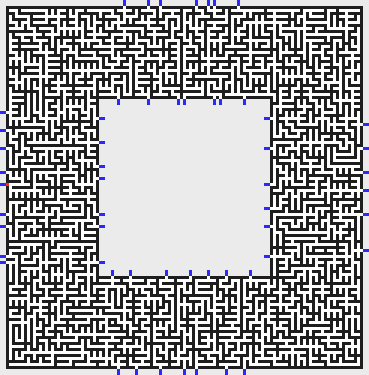

In [102]:
_ = day20(puzzle.input, visualize=True, speed=1)  # Slow: ~4 s.

""

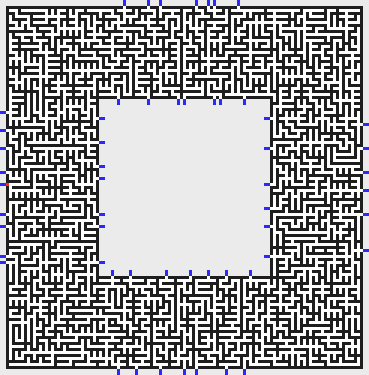

In [103]:
_ = day20_part2(puzzle.input, visualize=True, speed=2)  # Slow: ~25 s.

In [104]:
# See also visualizations in:
# https://www.reddit.com/user/seligman99/comments/ed7vee/day_20_running_through_the_depths_of_the_maze/
# https://kufii.github.io/Advent-Of-Code-2019-Solutions/
#  https://github.com/kufii/Advent-Of-Code-2019-Solutions/blob/master/src/solutions/20/index.js
#  Javascript code: https://imgur.com/NigyhsF

<a name="day21"></a>
## Day 21: Program jumping robot

Given an Intcode program for a jumping robot, provide as input a Springscript program to probe for holes in the ground and jump at the appropriate time.  Springscript has three instructions (`AND`, `OR`, and `NOT`), two registers (`T` and `J`), and two read-only input registers (`A`, `B`, `C`, and `D` that report `true` if there is ground at distance `1..4`).

- Part 1: Report the sum of output values from the successfully jumping robot.

- Part 2: The robot has increased sensor range (with registers `E`..`I`).  Report a sum of output as before.

In [105]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2019/day/21), `puzzle.input` has a single line of 7_326 characters:

109,2050,21101,0,966,1,21102,1,13,0,1105,1,1378,21102,1,20,0,1105,1,1337,21101,0 ... 1,-3,22201,-5,-3,-5,109,-6,2105,1,0


The stored answers are: `{1: '19348359', 2: '1140850168'}`

In [106]:
def day21_process_springscript(
    s, spring_program, verbose=False, command='WALK'):
  spring_program = spring_program + command + '\n'
  input = list(map(ord, spring_program))
  output = Machine.make(s).run_fully(input)
  value = output.pop() if output[-1] >= 128 else None
  last_moments = ''.join(map(chr, output))
  if verbose:
    print(last_moments)
  return value

In [107]:
# Both T and J are initially false.
# If jumping, the robot lands at cell +4.

In [108]:

def day21(s):
  # Success: Jump if there is ground at D and any of A,B,C are hole:
  # J = D AND NOT (A AND B AND C)
  spring_program = """\
    OR  A T
    AND B T
    AND C T
    NOT T J
    AND D J
  """
  return day21_process_springscript(s, spring_program)

puzzle.verify(1, day21)  # ~2 ms.

(Part 1: 0.001 s)


In [109]:
if 1:
  def day21_part1_test(*args, **kwargs):
    return day21_process_springscript(puzzle.input, *args, **kwargs)

  # Never jump: empty program
  check_eq(day21_part1_test("""\
  """), None)

  # Always jump: J = NOT J
  check_eq(day21_part1_test("""\
    NOT J J
  """), None)

  # Wait for the last moment to jump: J = (NOT A)
  check_eq(day21_part1_test("""\
  NOT A J
  """), None)

  # Jump if there is ground at D (+4): J = D
  check_eq(day21_part1_test("""\
    NOT D T
    NOT T J
  """), None)

  # Jump if there is ground at D unless both A and B are ground:
  # J = D AND NOT (A AND B)
  check_eq(day21_part1_test("""\
    OR  A T
    AND B T
    NOT T J
    AND D J
  """), None)

Part 2

In [110]:
if 1:
  def day21_part2_test(*args, **kwargs):
    kwargs.update(command='RUN')
    return day21_process_springscript(puzzle.input, *args, **kwargs)
  # The jump is still +4.  Only the sensor range is different (A-I).

  # Previous algorithm: Jump if there is ground at D and any of A,B,C are hole:
  # J = D AND NOT (A AND B AND C)
  check_eq(
      day21_part2_test("""\
     OR  A T
     AND B T
     AND C T
     NOT T J
     AND D J
  """), None)

In [111]:
def day21_part2(s):
  # Jump if there is ground at D and any of A,B,C are hole, except if E and H are holes.
  # J = D AND NOT (A AND B AND C) AND NOT (NOT E and NOT H)
  # J = D AND NOT (A AND B AND C) AND (E OR H)
  spring_program = """\
    OR  A T
    AND B T
    AND C T
    NOT T J
    AND D J
    NOT E T
    NOT T T
    OR  H T
    AND T J
  """
  return day21_process_springscript(s, spring_program, command='RUN')

puzzle.verify(2, day21_part2)  # ~16 ms with NumbaMachine; ~2400 ms without.

(Part 2: 0.006 s)


<a name="day22"></a>
## Day 22: Card-deck shuffle

Given a deck of cards labeled `0..10006`, apply the shuffling instructions in the input, consisting of `deal_into_new_deck` (reverse), `cut_n_cards` (rotate), and `deal_with_increment_n` (scatter at regular interval).

- Part 1: After shuffling, report the position of card `2019`.

- Part 2: Consider instead a deck of 119315717514047 cards, and apply the complete shuffle process 101741582076661 times in a row.  Report the card that ends up in position `2020`.

In [112]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2019/day/22), `puzzle.input` has 100 lines:

deal into new stack
deal with increment 68
cut 4888
deal with increment 44
cut -7998
deal into new stack
cut -5078
deal with increment 26
 ...
deal with increment 24
cut -3537
deal with increment 41
deal into new stack


The stored answers are: `{1: '5169', 2: '74258074061935'}`

In [113]:
day22_deck10_shuffles = [
    """\
deal with increment 7
deal into new stack
deal into new stack
Result: 0 3 6 9 2 5 8 1 4 7
""",
    """\
cut 6
deal with increment 7
deal into new stack
Result: 3 0 7 4 1 8 5 2 9 6
""",
    """\
deal with increment 7
deal with increment 9
cut -2
Result: 6 3 0 7 4 1 8 5 2 9
""",
    """\
deal into new stack
cut -2
deal with increment 7
cut 8
cut -4
deal with increment 7
cut 3
deal with increment 9
deal with increment 3
cut -1
Result: 9 2 5 8 1 4 7 0 3 6
""",
]

In [114]:
# Old version that keeps a list of cards:
class DeckOld:

  def __init__(self, arg):
    self.deck = list(range(int(arg))) if isinstance(arg, int) else list(arg)

  def cards(self):
    return self.deck

  def card_at_position(self, pos):
    return self.deck[pos]

  def position_of_card(self, i):
    return self.deck.index(i)

  def deal_into_new_stack(self):
    return DeckOld(reversed(self.deck))

  def cut_n_cards(self, n):
    n = n % len(self.deck)
    return DeckOld(self.deck[n:] + self.deck[:n])

  def deal_with_increment(self, n):
    size = len(self.deck)
    assert size % n > 0
    new_deck = [-1] * size
    position = 0
    for i in range(size):
      new_deck[position] = self.deck[i]
      position = (position + n) % size
    return DeckOld(new_deck)

In [115]:
# New version that keeps start and step.  Because the size of the card deck
# is prime, the shuffle deck can be represented as:
# (1) the position of card 0, and
# (2) the offset of card 1 relative to card 0, as 0 <= value < deck_size
# (This is similar to np.ndarray view with data and strides)
@dataclasses.dataclass
class Deck:
  size: int  # number of cards in deck
  start: int = 0  # zero-based position of card 0
  step: int = 1  # position of card 1 relative to card 0

  def __post_init__(self):
    assert math.gcd(self.step, self.size) == 1
    self.start %= self.size
    self.step %= self.size

  def cards(self):
    return [self.card_at_position(pos) for pos in range(self.size)]

  def card_at_position(self, pos):
    assert 0 <= pos < self.size
    # We solve for the card i that satisfies:
    #   pos == (start + step * i) % size   (with gcd(step, size) == 1)
    # using a modular inverse.
    inv_step = pow(self.step, -1, mod=self.size)
    return (inv_step * (pos - self.start)) % self.size

  def position_of_card(self, i):
    assert 0 <= i < self.size
    return (self.start + self.step * i) % self.size

  def deal_into_new_stack(self):
    return Deck(self.size, -1 - self.start, -self.step)

  def cut_n_cards(self, n):
    return Deck(self.size, self.start - n, self.step)

  def deal_with_increment(self, n):
    assert self.size % n > 0
    return Deck(self.size, self.start * n, self.step * n)

  def copy(self):
    return dataclasses.replace(self)

  def __mul__(self, other):
    return Deck(self.size, self.start + self.step * other.start, self.step * other.step)

  def __pow__(self, exponent):
    x = Deck(self.size)
    base = self.copy()
    while exponent > 0:
      if exponent % 2 == 1:
        x *= base
      base *= base
      exponent //= 2
    return x

  def apply_shuffle(self, shuffle):
    deck = self
    for line in shuffle.splitlines():
      if line == 'deal into new stack':
        deck = deck.deal_into_new_stack()
      elif line.startswith('cut '):
        n, = hh.re_groups(r'^cut ([\d-]+)', line)
        deck = deck.cut_n_cards(int(n))
      elif line.startswith('deal with increment '):
        n, = hh.re_groups(r'^deal with increment (\d+)', line)
        deck = deck.deal_with_increment(int(n))
      else:
        assert line.startswith('Result:')
    return deck

  def verify_shuffle(self, shuffle):
    deck = self.apply_shuffle(shuffle)
    line = shuffle.splitlines()[-1]
    assert line.startswith('Result:')
    expected = list(map(int, line[len('Result:'):].split()))
    check_eq(deck.cards(), expected)


def day22_test():
  deck = Deck(10)
  check_eq(deck.deal_into_new_stack().cards(), [9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
  check_eq(deck.cut_n_cards(3).cards(), [3, 4, 5, 6, 7, 8, 9, 0, 1, 2])
  check_eq(deck.cut_n_cards(-4).cards(), [6, 7, 8, 9, 0, 1, 2, 3, 4, 5])
  check_eq(deck.deal_with_increment(3).cards(), [0, 7, 4, 1, 8, 5, 2, 9, 6, 3])
  for s in day22_deck10_shuffles:
    Deck(10).verify_shuffle(s)
  check_eq(Deck(10007).apply_shuffle(puzzle.input).apply_shuffle(puzzle.input),
           Deck(10007).apply_shuffle(puzzle.input)**2)

day22_test()

In [116]:
def day22(s, *, part2=False):
  deck_size = 119315717514047 if part2 else 10007
  num_shuffles = 101741582076661 if part2 else 1
  deck = Deck(deck_size).apply_shuffle(s)**num_shuffles
  return deck.card_at_position(2020) if part2 else deck.position_of_card(2019)

puzzle.verify(1, day22)  # ~1 ms.

day22_part2 = functools.partial(day22, part2=True)
puzzle.verify(2, day22_part2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day23"></a>
## Day 23: Network of 50 machines

In [117]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2019/day/23), `puzzle.input` has a single line of 8_040 characters:

3,62,1001,62,11,10,109,2255,105,1,0,2049,1309,2018,1816,942,1585,571,1218,1554,2 ... ,72,1106,0,73,0,0,0,0,0,0,36,143734


The stored answers are: `{1: '21664', 2: '16150'}`

In [118]:
def day23(s, *, part2=False, num_machines=50):
  machines = [Machine.make(s) for _ in range(num_machines)]
  inputs = [collections.deque([i]) for i, machine in enumerate(machines)]
  nat_memory: tuple[int, int] | None = None
  previous_nat_memory: tuple[int, int] | None = None

  for step in itertools.count():
    for i, machine in enumerate(machines):
      output = machine.run_until_need_input([inputs[i].popleft() if inputs[i] else -1])
      for destination, x, y in more_itertools.chunked(output, 3):
        assert destination is not None and x is not None and y is not None  # Help mypy.
        if destination == 255:
          if not part2:
            return y
          nat_memory = x, y
          continue
        inputs[destination].extend([x, y])
    if step > 0 and not any(inputs):
      assert nat_memory is not None
      if nat_memory == previous_nat_memory:
        return nat_memory[1]  # Y value of nat_memory delivered twice in a row
      inputs[0].extend(nat_memory)
      previous_nat_memory = nat_memory

puzzle.verify(1, day23)  # ~36 ms.

day23_part2 = functools.partial(day23, part2=True)
puzzle.verify(2, day23_part2)  # ~132 ms.

(Part 1: 0.015 s)
(Part 2: 0.045 s)


<a name="day24"></a>
## Day 24: Game of life - nested rings

In [119]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2019/day/24), `puzzle.input` has 5 lines:

#.#.#
.#...
...#.
.###.
###.#


The stored answers are: `{1: '11042850', 2: '1967'}`

In [120]:
s1 = """\
....#
#..#.
#..##
..#..
#....
"""

In [121]:
def day24_part1(s):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1})
  visited = set()

  while True:
    counts = np.zeros_like(grid)
    counts[:4, :] += grid[1:, :]
    counts[1:, :] += grid[:4, :]
    counts[:, :4] += grid[:, 1:]
    counts[:, 1:] += grid[:, :4]
    grid = ((counts == 1) | ((grid == 0) & (counts == 2))).astype(int)
    t = tuple(grid.flat)
    if t in visited:
      return sum(value * 2**i for i, value in enumerate(t))
    visited.add(t)

check_eq(day24_part1(s1), 2129920)
puzzle.verify(1, day24_part1)  # ~1 ms.

(Part 1: 0.001 s)


In [122]:
def day24_part2(s, *, num_steps=200, visualize=False):
  abs_level = num_steps // 2 + 1  # slow propagation
  # Levels [-abs_level, abs_level] map to grid[1 : abs_level * 2 + 2].
  grid = np.zeros((abs_level * 2 + 3, 5, 5), np.int64)  # zero-padded
  grid[abs_level + 1] = hh.grid_from_string(s, {'.': 0, '#': 1})
  counts = np.empty_like(grid)

  def make_image(grid):
    grid = np.pad(grid.astype(bool), ((0, 0), (1, 1), (1, 1)))
    shape = -1, math.isqrt(len(grid))
    image = hh.assemble_arrays(grid, shape, round_to_even=True)
    return image.repeat(3, axis=0).repeat(3, axis=1)

  images = [make_image(grid)]
  for _ in range(num_steps):
    counts[:] = 0
    counts[1:-1, :4, :] += grid[1:-1, 1:, :]
    counts[1:-1, 1:, :] += grid[1:-1, :4, :]
    counts[1:-1, :, :4] += grid[1:-1, :, 1:]
    counts[1:-1, :, 1:] += grid[1:-1, :, :4]
    counts[1:-1, 0, :] += grid[:-2, 1, 2, None]
    counts[1:-1, 4, :] += grid[:-2, 3, 2, None]
    counts[1:-1, :, 0] += grid[:-2, 2, 1, None]
    counts[1:-1, :, 4] += grid[:-2, 2, 3, None]
    counts[1:-1, 1, 2] += grid[2:, 0, :].sum(axis=-1)
    counts[1:-1, 3, 2] += grid[2:, 4, :].sum(axis=-1)
    counts[1:-1, 2, 1] += grid[2:, :, 0].sum(axis=-1)
    counts[1:-1, 2, 3] += grid[2:, :, 4].sum(axis=-1)
    counts[:, 2, 2] = 0  # This absent center cell always remains inactive.
    grid = (counts == 1) | ((grid == 0) & (counts == 2))
    if visualize:
      images.append(make_image(grid))

  # print(grid.sum(axis=(1, 2)))  # Confirm that all levels are occupied.
  if visualize:
    images = [images[0]] * 30 + images + [images[-1]] * 90
    media.show_video(images, codec='gif', fps=25)  # ~1 MB embedded GIF.

  return np.count_nonzero(grid)

check_eq(day24_part2(s1, num_steps=10), 99)
puzzle.verify(2, day24_part2)  # ~36 ms.

(Part 2: 0.026 s)


In [123]:
if SHOW_BIG_MEDIA:
  _ = day24_part2(puzzle.input, visualize=True)  # ~3 s.

<a name="day25"></a>
## Day 25: Text adventure (n,s,e,w)

In [124]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2019/day/25), `puzzle.input` has a single line of 17_577 characters:

109,4806,21101,3124,0,1,21101,0,13,0,1105,1,1424,21102,1,166,1,21101,0,24,0,1105 ... 96,87,89,93,87,97,81,11,86,88,87,87


The stored answers are: `{1: '134349952', 2: ''}`

In [125]:
def day25(s, *, num_steps=2000):
  UNSAFE_ITEMS = {'photons', 'infinite loop', 'giant electromagnet',
                  'molten lava', 'escape pod'}
  # 'It is suddenly completely dark! You are eaten by a Grue!'
  # 'The giant electromagnet is stuck to you.  You can't move!!'
  # 'The molten lava is way too hot! You melt!'
  # 'You're launched into space! Bye!'

  machine = Machine.make(s)
  command = ''
  inventory = set()
  locations = set()

  def encode(command):
    return [ord(ch) for ch in command + '\n']

  def decode(output):
    return ''.join(chr(e) for e in output)

  def issue_command(command):
    return decode(machine.run_until_need_input(encode(command) if command else []))

  for step in range(num_steps):
    message = issue_command(command)
    pattern = r'(?s)^\n*== (.*) ==\n(.*)\n\n(Doors here.*?)(Items here.*)?$'
    location, description, s_doors, s_items = hh.re_groups(pattern, message)
    doors = re.findall(r'(?m)^- (\S+)$', s_doors)
    items = re.findall(r'(?m)^- (.*?)$', s_items if s_items else '')
    locations.add(f'{location:<23} {description:<82} [{" ".join(d[0] for d in doors)}]')

    for item in items:
      if item not in UNSAFE_ITEMS:
        message = issue_command(f'take {item}')
        inventory.add(item)

    if location == 'Security Checkpoint':
      if step >= num_steps * 0.5:
        break  # By now we should have taken all the safe items.
      command = 'east'  # Avoid 'north' to get more time to pick up items.
      continue
    command = random.choice(doors)
  else:
    assert False

  if 0:
    print('\n'.join(sorted(locations)))
    print(sorted(inventory))  # or: issue_command('inv')
    # ['astrolabe', 'candy cane', 'dark matter', 'hologram', 'klein bottle', 'ornament', 'tambourine', 'whirled peas']
  for items2 in (set(l) for l in more_itertools.powerset(inventory)):
    for item in inventory:
      command = 'take' if item in items2 else 'drop'
      message = issue_command(f'{command} {item}')
    message = issue_command('north')
    if match := re.search(r'typing (\d+) on the keypad', message):
      if 0:
        print(sorted(items2))  # ['astrolabe', 'hologram', 'klein bottle', 'tambourine']
      return match.group(1)


puzzle.verify(1, day25)  # ~215 ms.

(Part 1: 0.096 s)


In [126]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [127]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.001   part_2: 0.088
day_3    part_1: 0.096   part_2: 0.087
day_4    part_1: 0.002   part_2: 0.002
day_5    part_1: 0.000   part_2: 0.000
day_6    part_1: 0.015   part_2: 0.000
day_7    part_1: 0.030   part_2: 0.037
day_8    part_1: 0.003   part_2: 0.005
day_9    part_1: 0.000   part_2: 0.004
day_10   part_1: 0.069   part_2: 0.071
day_11   part_1: 0.016   part_2: 0.001
day_12   part_1: 0.004   part_2: 0.019
day_13   part_1: 0.001   part_2: 0.031
day_14   part_1: 0.001   part_2: 0.017
day_15   part_1: 0.013   part_2: 0.013
day_16   part_1: 0.042   part_2: 0.135
day_17   part_1: 0.002   part_2: 0.008
day_18   part_1: 0.176   part_2: 0.216
day_19   part_1: 0.120   part_2: 0.166
day_20   part_1: 0.019   part_2: 0.033
day_21   part_1: 0.001   part_2: 0.006
day_22   part_1: 0.000   part_2: 0.000
day_23   part_1: 0.015   part_2: 0.045
day_24   part_1: 0.001   part_2: 0.026
day_25   part_1: 0.096   part_2: 0.000
Total time:  1.731 s


In [128]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [129]:
if 1:  # Look for unwanted pollution of namespace.
  print(textwrap.fill(' '.join(name for name, value in globals().items() if not (
      name.startswith(('_', 'day', 'Day')) or name in _ORIGINAL_GLOBALS))))

Machine PyMachine test_machine_py NumbaMachine test_machine puzzle s1
s2 s3 s4 s5 s11 s12 s13 s14 DeckOld Deck


In [130]:
if 0:  # Save puzzle inputs and answers to a compressed archive for downloading.
  # Create a new tar.gz file.
  hh.run(f"""cd /mnt/c/hh/tmp && cp -rp ~/.config/aocd/'{PROFILE.replace("_", " ")}' '{PROFILE}' && tar -czf '{PROFILE}.tar.gz' '{PROFILE}'""")

In [131]:
if 0:  # Look for misspelled words.
  hh.run(rf"""cat advent_of_code_{YEAR}.py | perl -pe "s@https?:/.*?[)> ]@@g; s/'/ /g; s/\\\\n//g;" | spell | sort -u || true""")

In [132]:
if 0:  # Lint.
  hh.run('echo flake8; flake8')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pylint; pylint -j8 . || true')
  print('All ran.')

In [133]:
hh.show_notebook_cell_top_times()

# Total time: 34.08 s
# In[103] _ = day20_part2(puzzle.input, visualize=True, speed=2)  #   11.680 s
# In[ 90] _ = day18(puzzle.input, visualize=True, speed=3, tail=2)  #  4.563 s
# In[ 92] _ = day18_part2(puzzle.input, visualize=True, speed=2,       3.396 s
# In[102] _ = day20(puzzle.input, visualize=True, speed=1)  # Slow: ~  2.243 s
# In[ 16] def test_machine(machine_type):\n  def mem_after_machine_    1.843 s
# In[ 50] _ = day11(puzzle.input, visualize_nth=8)\n_ = day11_part2(   1.228 s
# In[ 68] _ = Day15ExploreMaze(puzzle.input).farthest_distance_from_   0.964 s
# In[ 27] # Using numba to operate on dict is slow.\n\n@numba.         0.865 s
# In[ 59] _ = day13_part2(puzzle.input, visualize=True)                0.713 s
# In[ 88] def day18(s, *, part2=False, visualize=False, fps=50, size=  0.554 s
# In[ 47] _ = day10_part2(puzzle.input, visualize=True)                0.470 s
# In[ 97] _ = day19_part2(puzzle.input, visualize=True)  # Slow; ~3.8  0.467 s
# In[ 46] @numba.njit\ndef day

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->